Author: Josh Kuppersmith

Date: March 29, 2018

Subject: Modeling Notebook, Homogeneity Metrics, Clustering, and Optimizing

Hopefully the final major notebook to get model results before a full draft

Advisor: Pavlos Protopapas


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy
import sklearn
from operator import add
import csv 
import gmaps
import overpy
import math
import geoplotlib
import seaborn as sns
from mpl_toolkits.basemap import Basemap
import warnings
import geopandas
from geopandas.tools import sjoin
from matplotlib.patches import Polygon
from shapely.geometry import shape, Point
import shapely
import fiona
from copy import deepcopy
from math import log
from decimal import Decimal
import time
import geopy.distance
import random
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

import xgboost as xgb
from sklearn.metrics import accuracy_score, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from sklearn.cluster import KMeans

# note: learn more about EMD and how to use it
#from pyemd import emd
from pyemd import emd_samples

pd.set_option('display.max_columns', 500)
warnings.filterwarnings("ignore")
plt.style.use('seaborn')

#### Introduction/Notebook Description: 

In this notebook, we complete both baseline and project models. These are clustering models. A key piece of this is the metric by which we measure success of clustering. For this we use earth moving distance to measure tightness of cluster, which is focused on crime profiles across cells in a given neighborhood.

#### Running Instructions: 

Run like normal. First section will load the data from our pre-processing and EDA, then the rest runs models, with bolded headers between each so that we can run them separately if we want. See previous notebooks (or writeup) for more detailed information about models 


In [10]:
# Load in Accumulated final gridded datasets
crime_grid = pd.read_csv("Cleaned/Accumulated_Crime_15_18.csv")
feature_grid = pd.read_csv("Cleaned/Accumulated_Grid_Features.csv")
full_grid = pd.read_csv("Cleaned/Merged_Grid_Data.csv")
clustering_grid = pd.read_csv('Cleaned/Accumulated_Grid_10Yr.csv')

In [11]:
print("Size of Grid: " + str(len(clustering_grid)) + " cells")
clustering_grid.head()

Size of Grid: 3177 cells


,Unnamed: 0,All Crime,Assault,Battery,Burglary,Deceptive,Homicide,Latitude,Longitude,Motor,Narcotics,Robbery,Theft,Trespassing,Weapons,lat,lon,coord,Neighborhoods,Beats,Cell Towers,waste_basket,library,grave_yard,fire_station,drinking_water,fountain,pub,bicycle_parking,pharmacy,bar,bank,bicycle_rental,bench,cafe,fuel,fast_food,school,restaurant,place_of_worship,parking,Divvy,Bike Rack,Bus Stop,L Stop,Metra
0,0,1074,48,158,29,16,1,42.022458,-87.675421,14,77,28,86,30,15,42.022458,-87.675421,"('-87.675421179', '42.0224578821')",48,31,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,1,2,0,0
1,1,2600,219,674,97,53,6,42.022458,-87.670930,40,381,73,288,161,55,42.022458,-87.670930,"('-87.6709296026', '42.0224578821')",48,31,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0
2,2,948,72,247,63,40,4,42.022458,-87.666438,18,49,22,191,30,13,42.022458,-87.666438,"('-87.6664380261', '42.0224578821')",48,31,9,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0
3,3,61,2,14,4,6,0,42.017966,-87.819152,1,0,0,19,4,0,42.017966,-87.819152,"('-87.8191516244', '42.0179663057')",73,33,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,70,4,4,5,14,0,42.017966,-87.814660,0,0,1,21,4,0,42.017966,-87.814660,"('-87.814660048', '42.0179663057')",73,33,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


***

# Standard Deviation Measure for Within-Cluster Inhomogeneity (Replacing Entropy): 

Higher entropy means that there is more inhomogeneity in the neighborhood

***

In [12]:
# function that takes in data and the column where it finds cluster labels
# and returns the sizes of each 
def sd(data, cluster_col):
    e_data = data[data[cluster_col] > -1]
    max_clust = np.max(list(e_data[cluster_col]))
    sd_list = []
                       
    for i in list(set(list(e_data[cluster_col]))):
        clust_data = e_data[e_data[cluster_col] == i]
        sd = math.sqrt(np.var(list(clust_data['All Crime'])))
        sd_list.append(sd)
        
    return sd_list

sd_list = sd(clustering_grid, 'Neighborhoods')
for i in range(10):
    print(sd_list[i], len(clustering_grid[clustering_grid.Neighborhoods == i]))
print
print("We can see that small neighborhoods tend to have very small standard deviation which makes sense")



(676.6221563029103, 25)
(0.0, 1)
(1049.3717146729064, 15)
(521.9896550699066, 5)
(1243.355525706861, 55)
(1525.3917249835245, 51)
(1432.6009891262006, 46)
(781.156488241824, 67)
(398.4123076210188, 13)
(344.5136007384179, 16)

We can see that small neighborhoods tend to have very small standard deviation which makes sense


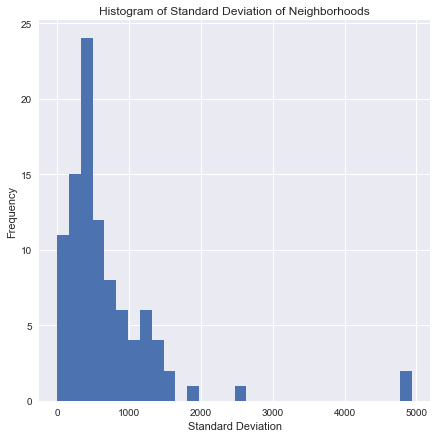

In [13]:
plt.figure(figsize=(7,7))
plt.hist(sd_list, bins=30)
plt.title("Histogram of Standard Deviation of Neighborhoods")
plt.ylabel("Frequency")
plt.xlabel("Standard Deviation")
plt.show()

In [14]:
# Neighborhood 5, 12, and 17 analysis

print("Here are 3 neighborhoods with very different Standard Deviation values for 'All Crime.'")
print("These are the same as the ones we will use to calculate EMD. These illustrate the way that")
print("SD handles scale of data, the spread of the distribution, and multimodality of distributions.")
print
#print(len(clustering_grid[clustering_grid.Neighborhoods == 5]))
print("Neighborhood 5 (size 51) All Crime SD: " + str(sd_list[5]))
print("Neighborhood 12 (size 34) All Crime SD: " + str(sd_list[12]))
print("Neighborhood 17 (size 58) All Crime SD: " + str(sd_list[17]))

Here are 3 neighborhoods with very different Standard Deviation values for 'All Crime.'
These are the same as the ones we will use to calculate EMD. These illustrate the way that
SD handles scale of data, the spread of the distribution, and multimodality of distributions.

Neighborhood 5 (size 51) All Crime SD: 1525.39172498
Neighborhood 12 (size 34) All Crime SD: 515.07534051
Neighborhood 17 (size 58) All Crime SD: 313.797337978


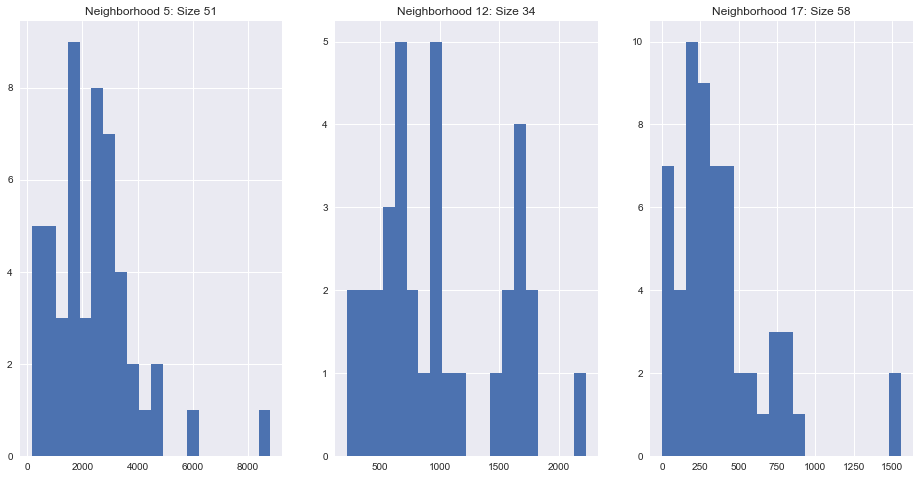

In [15]:
fig, axs = plt.subplots(1,3, figsize=(16,8))
axs[0].hist(clustering_grid[clustering_grid.Neighborhoods == 5]['All Crime'], bins=20)
axs[0].set_title('Neighborhood 5: Size 51')
axs[1].hist(clustering_grid[clustering_grid.Neighborhoods == 12]['All Crime'], bins=20)
axs[1].set_title('Neighborhood 12: Size 34')
axs[2].hist(clustering_grid[clustering_grid.Neighborhoods == 17]['All Crime'], bins=20)
axs[2].set_title('Neighborhood 17: Size 58')
plt.show()

Will be interesting to see how this compares to EMD.

***
# Earth Mover's Distance for Measuring Within-Cluster Similarity
***

In [16]:
def emd(data, cluster_col):
    clusters = data[cluster_col]
    max_clust = np.max(list(clusters))
    
    cluster_emd_vecs = []
    cluster_emd_aves = []
    # iterate through clusters
    for cluster in range(max_clust+1):
        cluster_data = data[data[cluster_col] == cluster]
        cluster_size = len(cluster_data)
        if cluster_size == 0:
            #print("Cluster Size 0 error")
            continue
        
        crime_list = list(cluster_data['All Crime'])
        comparison_dist = []
        neighborhood_mean = np.mean(crime_list)
        sq_mu = math.sqrt(neighborhood_mean)
        for i in range(len(crime_list)):
            comparison_dist.append(neighborhood_mean + np.random.uniform(-1.0*sq_mu, sq_mu))
        cluster_emd_vecs.append(emd_samples(crime_list, comparison_dist))

    return cluster_emd_vecs

Average EMD for several crime types for 'Neighborhoods': 525.419359851
Average EMD for several crime types for 'Beats': 526.663045148


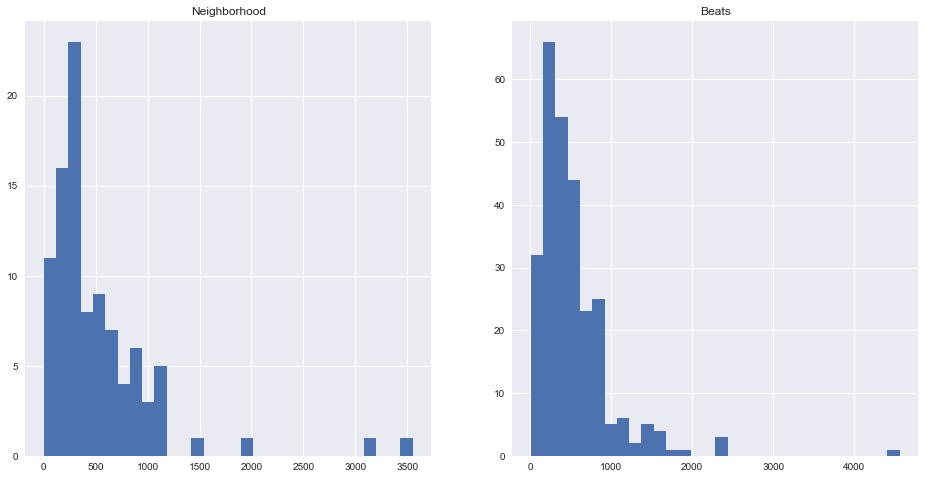

In [17]:
averages = emd(clustering_grid[clustering_grid.Neighborhoods > -1], 'Neighborhoods')
averages2 = emd(clustering_grid[clustering_grid.Beats > -1], 'Beats')

print("Average EMD for several crime types for 'Neighborhoods': " + str(np.mean(averages)))
print("Average EMD for several crime types for 'Beats': " + str(np.mean(averages2)))

fig, axs = plt.subplots(1,2, figsize=(16,8))
axs[0].hist(averages, bins=30)
axs[1].hist(averages2, bins=30)
axs[0].set_title("Neighborhood")
axs[1].set_title("Beats")
plt.show()

In [18]:
# Neighborhood 5, 12, and 17 analysis

print("Here are 3 neighborhoods with very different EMD values for 'All Crime'. These illustrate the way that")
print("EMD scale of data, the spread of the distribution, and multimodality of distributions.")
print
#print(len(clustering_grid[clustering_grid.Neighborhoods == 5]))
print("Neighborhood 5 (size 51) All Crime EMD: " + str(averages[5]))
print("Neighborhood 12 (size 34) All Crime EMD: " + str(averages[12]))
print("Neighborhood 12 (size 58) All Crime EMD: " + str(averages[17]))


Here are 3 neighborhoods with very different EMD values for 'All Crime'. These illustrate the way that
EMD scale of data, the spread of the distribution, and multimodality of distributions.

Neighborhood 5 (size 51) All Crime EMD: 1081.88914434
Neighborhood 12 (size 34) All Crime EMD: 421.171683659
Neighborhood 12 (size 58) All Crime EMD: 205.062438984


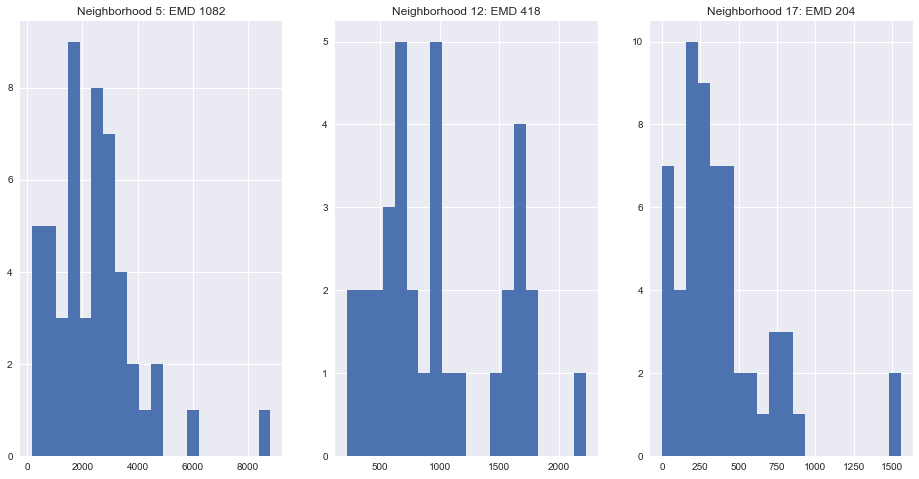

In [19]:
fig, axs = plt.subplots(1,3, figsize=(16,8))
axs[0].hist(clustering_grid[clustering_grid.Neighborhoods == 5]['All Crime'], bins=20)
axs[0].set_title('Neighborhood 5: EMD 1082')
axs[1].hist(clustering_grid[clustering_grid.Neighborhoods == 12]['All Crime'], bins=20)
axs[1].set_title('Neighborhood 12: EMD 418')
axs[2].hist(clustering_grid[clustering_grid.Neighborhoods == 17]['All Crime'], bins=20)
axs[2].set_title('Neighborhood 17: EMD 204')
plt.show()

#### EMD Punishes multimodality more so that is why we will use it. Multi-modality is really bad for trying to create homogeneous neighborhoods that we can use to differetiate areas. Also, looking at some work, it seems that the difference between SD mean and median is usually greater than for EMD, and given that either of these metrics could work, I trust EMD more because it is more consistent between them. 

***
# Baseline 1 - City Neighborhood Boundaries

### Get baseline numbers, visuals of all crime EMD and Entropy
***

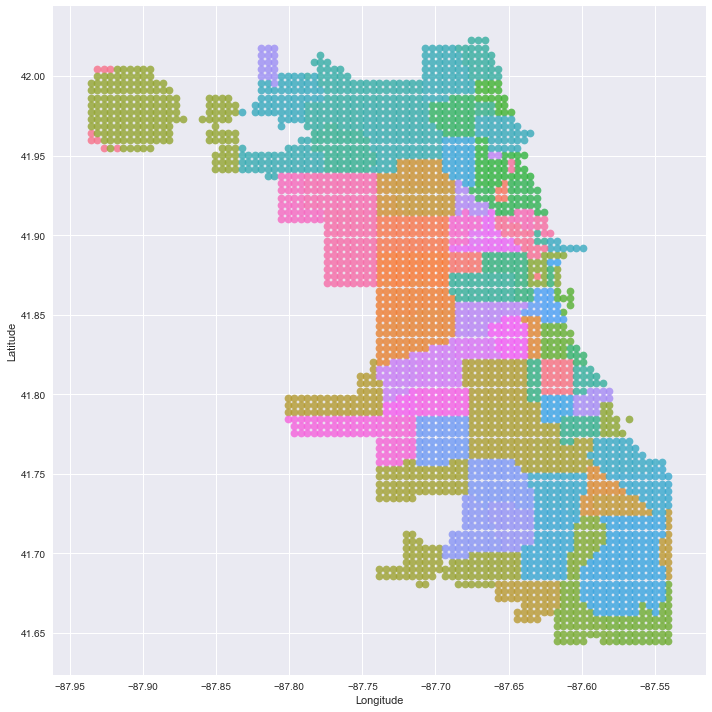

In [20]:
sns.lmplot(x="Longitude", y="Latitude", data=clustering_grid, fit_reg=False, hue='Neighborhoods', legend=False, scatter_kws={"s": 60}, size=10)
plt.show()

Neighborhoods are pretty irregular, but mostly not jagged or disconnected. Important things to note for the regularization step, which is meant to enforce contiguousness in the neighborhood boundaries. 

In [21]:
print("Number of Neighborhoods: " + str(len(np.unique(list(clustering_grid.Neighborhoods)))))

start1 = time.time()
all_c_emd = emd(clustering_grid[clustering_grid.Neighborhoods > -1], 'Neighborhoods')
emd_time = time.time() - start1

start2  = time.time()
all_c_sd = sd(clustering_grid[clustering_grid.Neighborhoods > -1], 'Neighborhoods')
sd_time = time.time() - start2

print
print("The average neighborhood all crime EMD is: " + str(np.mean(all_c_emd)) + ", the median is: " + str(np.median(all_c_emd)) + ", the maximum is: " + str(np.max(all_c_emd)) + ", and the minimum is: " + str(np.min(all_c_emd)))
print("EMD Calculation took: " + str(emd_time))
print
print("The average neighborhood all crime Standard Deviation is: " + str(np.mean(all_c_sd)) + ", the median is: " + str(np.median(all_c_sd)) + ", the maximum is: " + str(np.max(all_c_sd)) + ", and the minimum is: " + str(np.min(all_c_sd)))
print("Variance Calculation took: " + str(sd_time))

Number of Neighborhoods: 97

The average neighborhood all crime EMD is: 524.27949043, the median is: 352.829801536, the maximum is: 3553.33155666, and the minimum is: 5.03455293592
EMD Calculation took: 0.245812177658

The average neighborhood all crime Standard Deviation is: 698.963788041, the median is: 464.870810579, the maximum is: 4939.82599784, and the minimum is: 0.0
Variance Calculation took: 0.0920979976654


So we've learned a few things. First, median and mean are very different for these across neighborhood calculations. Median seems to be the better way to go, since huge numbers are skewing this in both cases, though we should figure out where the huge and tiny numbers are coming from (sizes of neighborhoods? location). Also, we learned that an Entropy calculation takes ~8x longer to run than entropy, so maybe for the sake of training, EMD is the better way to go. 

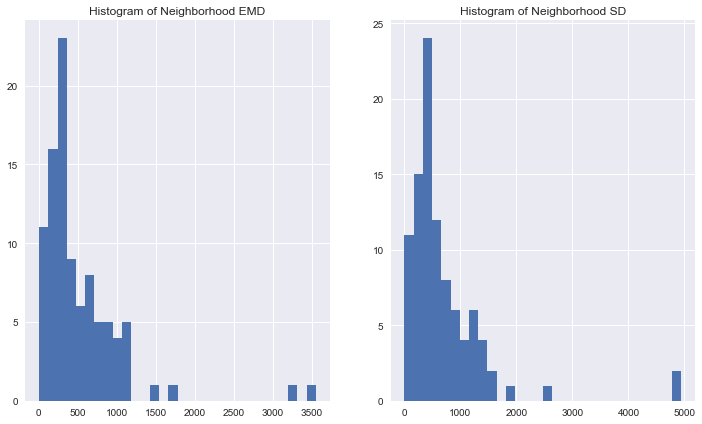

In [22]:
fig, ax = plt.subplots(1,2, figsize=(12,7))
ax[0].hist(all_c_emd, bins=30)
ax[0].set_title("Histogram of Neighborhood EMD")
ax[1].hist(all_c_sd, bins=30)
ax[1].set_title("Histogram of Neighborhood SD")
plt.show()

While both are influenced by outliers, the they look very similar.

***
# Baseline 2 - Police Beats

### Get baseline numbers, visuals of all crime EMD
***

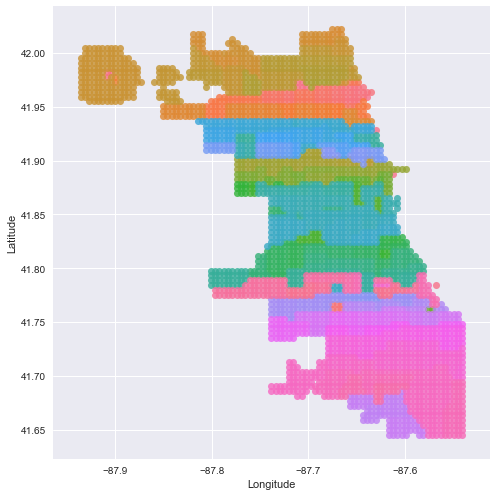

In [23]:
sns.lmplot(x="Longitude", y="Latitude", data=clustering_grid, fit_reg=False, hue='Beats', legend=False, scatter_kws={"s": 50}, size=7)
plt.show()

In [24]:
print("Number of Beats: " + str(len(np.unique(list(clustering_grid.Beats)))))

start1 = time.time()
all_c_emd_beat = emd(clustering_grid[clustering_grid.Beats > -1], 'Beats')
emd_time = time.time() - start1

start2  = time.time()
all_c_sd_beat = sd(clustering_grid[clustering_grid.Beats > -1], 'Beats')
var_time = time.time() - start2

print
print("The average Beat all crime EMD is: " + str(np.mean(all_c_emd_beat)) + ", the median is: " + str(np.median(all_c_emd_beat)) + ", the maximum is: " + str(np.max(all_c_emd_beat)) + ", and the minimum is: " + str(np.min(all_c_emd_beat)))
print("EMD Calculation took: " + str(emd_time))
print
print("The average Beat all crime Standard Deviation is: " + str(np.mean(all_c_sd_beat)) + ", the median is: " + str(np.median(all_c_sd_beat)) + ", the maximum is: " + str(np.max(all_c_sd_beat)) + ", and the minimum is: " + str(np.min(all_c_sd_beat)))
print("Variance Calculation took: " + str(sd_time))

Number of Beats: 273

The average Beat all crime EMD is: 522.359094549, the median is: 394.771665742, the maximum is: 4560.328773, and the minimum is: 0.0
EMD Calculation took: 0.478772878647

The average Beat all crime Standard Deviation is: 679.736688142, the median is: 530.181160666, the maximum is: 5963.46735456, and the minimum is: 0.0
Variance Calculation took: 0.0920979976654


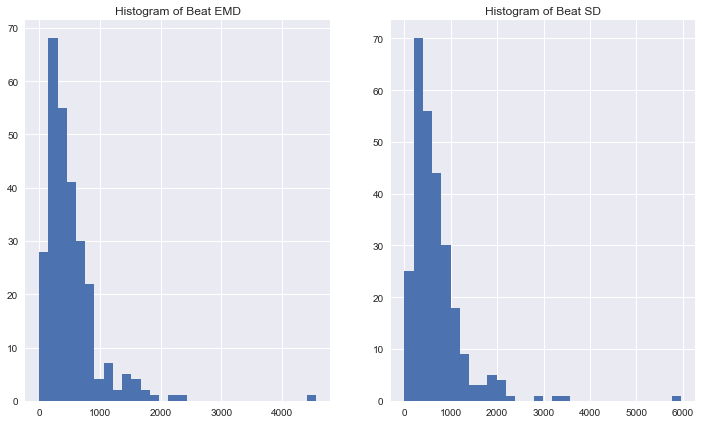

In [25]:
fig, ax = plt.subplots(1,2, figsize=(12,7))
ax[0].hist(all_c_emd_beat, bins=30)
ax[0].set_title("Histogram of Beat EMD")
ax[1].hist(all_c_sd_beat, bins=30)
ax[1].set_title("Histogram of Beat SD")
plt.show()

Looks surprisingly normal for beats! Could be a good feature. One note is that since there are so many beats, it will be logistically tough to run models with k=~270 that can be used to compare against this baseline, so Neighborhoods is probably a stronger baseline. Also, in terms of the narrative, Neighborhoods probably makes more sense.

***
# Naive K-Means Geographic Clustering
***

#### Naive geographical clustering just using latitude and longitude with sklearn kmeans

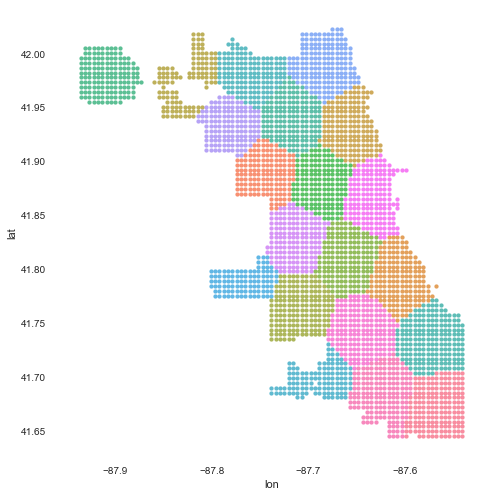

The average Cluster all crime EMD is: 551.927537314, the median is: 543.940084286, the maximum is: 1325.82294374, and the minimum is: 109.432994447

The average Cluster all crime Standard Deviation is: 803.866805826, the median is: 755.264687355, the maximum is: 2436.55839237, and the minimum is: 158.447452955


In [26]:
predictors_simple = ["lat", "lon"]

X = clustering_grid[predictors_simple]
kmeans = KMeans(n_clusters=20)
kmeans.fit(X)
y_km = kmeans.fit_predict(X)
clustering_grid['Cluster'] = y_km

sns.set_style("white")
sns.lmplot(x="lon", y="lat", data=clustering_grid, fit_reg=False, hue='Cluster', legend=False, scatter_kws={"s": 18}, size=7)
plt.show()

all_c_emd_clust = emd(clustering_grid[clustering_grid.Cluster > -1], 'Cluster')
all_c_sd_clust = sd(clustering_grid[clustering_grid.Cluster > -1], 'Cluster')
print("The average Cluster all crime EMD is: " + str(np.mean(all_c_emd_clust)) + ", the median is: " + str(np.median(all_c_emd_clust)) + ", the maximum is: " + str(np.max(all_c_emd_clust)) + ", and the minimum is: " + str(np.min(all_c_emd_clust)))
print
print("The average Cluster all crime Standard Deviation is: " + str(np.mean(all_c_sd_clust)) + ", the median is: " + str(np.median(all_c_sd_clust)) + ", the maximum is: " + str(np.max(all_c_sd_clust)) + ", and the minimum is: " + str(np.min(all_c_sd_clust)))


#### Another naive attempt using sklearn Kmeans on lat, lon, and cell towers - messes the whole thing up. Likely due to scale, would be interesting to see the results if we were to normalize the data. 

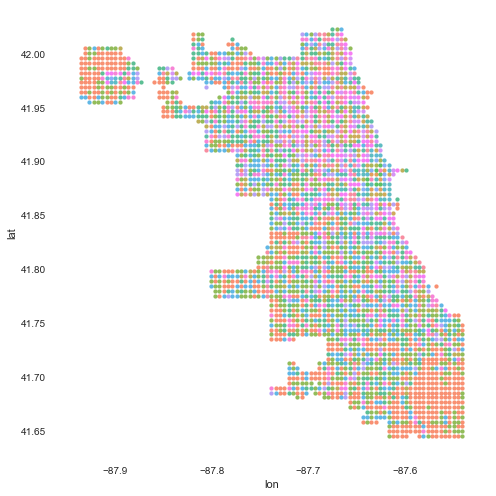

The average Cluster all crime EMD is: 1127.22596051, the median is: 767.006172671, the maximum is: 4045.37410588, and the minimum is: 372.356403477

The average Cluster all crime Standard Deviation is: 1584.80851211, the median is: 1059.98567628, the maximum is: 6092.1530258, and the minimum is: 563.006510933


In [27]:
predictors = ["Cell Towers", "lat", "lon"]

X = clustering_grid[predictors]
kmeans = KMeans(n_clusters=20)
kmeans.fit(X)
y_km = kmeans.fit_predict(X)
clustering_grid['Cluster'] = y_km

sns.set_style("white")
sns.lmplot(x="lon", y="lat", data=clustering_grid, fit_reg=False, hue='Cluster', legend=False, scatter_kws={"s": 18}, size=7)
plt.show()

all_c_emd_clust = emd(clustering_grid[clustering_grid.Cluster > -1], 'Cluster')
all_c_sd_clust = sd(clustering_grid[clustering_grid.Cluster > -1], 'Cluster')
print("The average Cluster all crime EMD is: " + str(np.mean(all_c_emd_clust)) + ", the median is: " + str(np.median(all_c_emd_clust)) + ", the maximum is: " + str(np.max(all_c_emd_clust)) + ", and the minimum is: " + str(np.min(all_c_emd_clust)))
print
print("The average Cluster all crime Standard Deviation is: " + str(np.mean(all_c_sd_clust)) + ", the median is: " + str(np.median(all_c_sd_clust)) + ", the maximum is: " + str(np.max(all_c_sd_clust)) + ", and the minimum is: " + str(np.min(all_c_sd_clust)))


#### Normalize features then run the above naive k-means to see results

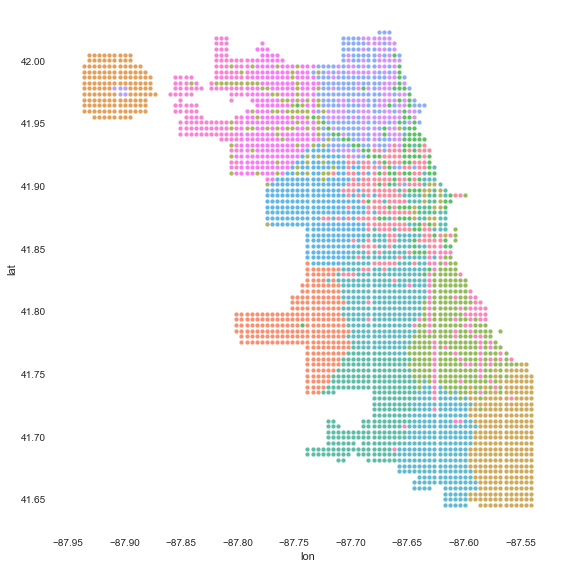

The average Cluster all crime EMD is: 797.551802735, the median is: 577.291891476, the maximum is: 3007.69006445, and the minimum is: 40.6040859345

The average Cluster all crime Standard Deviation is: 1160.52068868, the median is: 793.021055818, the maximum is: 3910.43956198, and the minimum is: 125.629725033


In [28]:
predictors = ["Cell Towers", "lat", "lon"]

X = clustering_grid[predictors]
normalized_X=(X-X.mean())/X.std()
kmeans = KMeans(n_clusters=20)
kmeans.fit(normalized_X)
y_km = kmeans.fit_predict(normalized_X)
clustering_grid['Cluster'] = y_km

sns.set_style("white")
sns.lmplot(x="lon", y="lat", data=clustering_grid, fit_reg=False, hue='Cluster', legend=False, scatter_kws={"s": 18}, size=8)
plt.show()

all_c_emd_clust = emd(clustering_grid[clustering_grid.Cluster > -1], 'Cluster')
all_c_sd_clust = sd(clustering_grid[clustering_grid.Cluster > -1], 'Cluster')
print("The average Cluster all crime EMD is: " + str(np.mean(all_c_emd_clust)) + ", the median is: " + str(np.median(all_c_emd_clust)) + ", the maximum is: " + str(np.max(all_c_emd_clust)) + ", and the minimum is: " + str(np.min(all_c_emd_clust)))
print
print("The average Cluster all crime Standard Deviation is: " + str(np.mean(all_c_sd_clust)) + ", the median is: " + str(np.median(all_c_sd_clust)) + ", the maximum is: " + str(np.max(all_c_sd_clust)) + ", and the minimum is: " + str(np.min(all_c_sd_clust)))


#### These results actually don't look too bad, but if we add more features, the neighborhoods stop making sense, illustrating the need for our algorithm

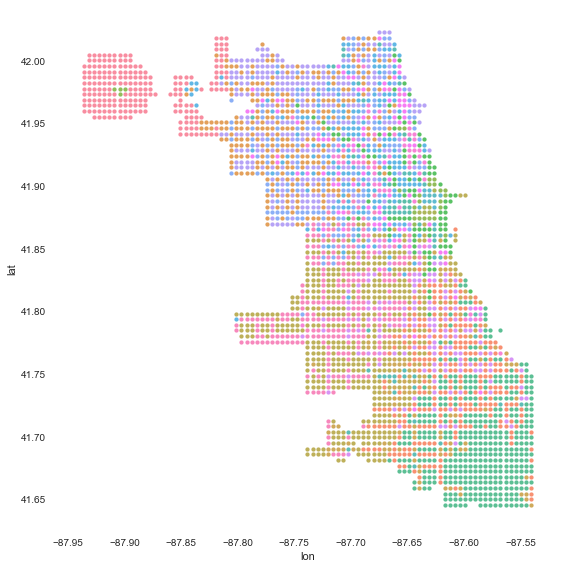

The average Cluster all crime EMD is: 935.950394389, the median is: 733.91837247, the maximum is: 3166.14625091, and the minimum is: 56.003547302

The average Cluster all crime Standard Deviation is: 1332.74665498, the median is: 1014.83649406, the maximum is: 5132.61856496, and the minimum is: 116.57362213


In [29]:
predictors = ["Cell Towers", "restaurant", "Bus Stop", "parking", "lat", "lon"]

X = clustering_grid[predictors]
normalized_X=(X-X.mean())/X.std()
kmeans = KMeans(n_clusters=20)
kmeans.fit(normalized_X)
y_km = kmeans.fit_predict(normalized_X)
clustering_grid['Cluster'] = y_km

sns.set_style("white")
sns.lmplot(x="lon", y="lat", data=clustering_grid, fit_reg=False, hue='Cluster', legend=False, scatter_kws={"s": 18}, size=8)
plt.show()

all_c_emd_clust = emd(clustering_grid[clustering_grid.Cluster > -1], 'Cluster')
all_c_sd_clust = sd(clustering_grid[clustering_grid.Cluster > -1], 'Cluster')
print("The average Cluster all crime EMD is: " + str(np.mean(all_c_emd_clust)) + ", the median is: " + str(np.median(all_c_emd_clust)) + ", the maximum is: " + str(np.max(all_c_emd_clust)) + ", and the minimum is: " + str(np.min(all_c_emd_clust)))
print
print("The average Cluster all crime Standard Deviation is: " + str(np.mean(all_c_sd_clust)) + ", the median is: " + str(np.median(all_c_sd_clust)) + ", the maximum is: " + str(np.max(all_c_sd_clust)) + ", and the minimum is: " + str(np.min(all_c_sd_clust)))


***
# Pure Geographic Clustering Function

Instructions for goal are above. Upon researching online, it seems that it may not be possible to use sklearn to define my own distance and centroid function, so I will probably have to implement this myself. 
***

https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude

In [30]:
from math import radians, cos, sin, asin, sqrt

def hav_dist(lat1, lon1, lat2, lon2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    c = 2 * asin(sqrt(sin((lat2 - lat1) /2)**2 + cos(lat1) * cos(lat2) * sin((lon2 - lon1) /2)**2)) * 6371 # Radius of earth in kilometers
    return c

#def hav_dist_2(lat1, lon1, lat2, lon2):
#    s15 = time.time()
#    coords_1 = (lat1, lon1)
#    coords_2 = (lat2, lon2)
#    d = geopy.distance.distance(coords_1, coords_2).km
#    print("Hav2 took: " + str(time.time()-s15))
#    return d

Hav1 is fastest, seems tough to improve it

In [31]:
clustering_data = clustering_grid[['Latitude', 'Longitude']]

def pure_geo_k_means(data, k, cap=1000, verbose=False):
    # store error for iteration analysis
    s1 = time.time()
    error_mags = []
    sse = []
    C_x = []
    C_y = []
    rand_inds = random.sample(range(0, len(data)), k)

    arr = data.iloc[rand_inds][['Latitude','Longitude']]
    centroids_curr = np.array(arr, dtype=np.float32)
    # centroid storage
    centroids_old = np.zeros((k,2))
    # cluster label
    clusters = np.zeros(len(data))
    ideal_error = list(np.zeros(k))
    error = []
    
    for i in range(k):
        # lats and lons for haversine distance
        error.append(hav_dist(centroids_old[i][0], centroids_old[i][1], centroids_curr[i][0], centroids_curr[i][1]))
    itera = 0
    while not error == ideal_error:
        s2 = time.time()
        itera += 1
        
        # stop early
        if itera > cap:
            break
        
        if verbose:
            print("Iteration: " + str(itera))
        
        for i in range(len(data)):
            distances = []
            lat = data.at[i, 'Latitude']
            lon = data.at[i, 'Longitude']
            for j in range(len(centroids_curr)):
                distances.append(hav_dist(centroids_curr[j][0], centroids_curr[j][1], lat, lon))
            cluster_num = np.argmin(distances)
            clusters[i] = cluster_num
        # Store old centroid values
        C_old_store = deepcopy(centroids_curr)
        data.temp_clust = clusters
        
        sse_iter = 0
        for i in range(k):
            points_in_clust = data[data.temp_clust == i][['Latitude', 'Longitude']]
            point_mean = np.mean(points_in_clust, axis=0)
            centroids_curr[i] = point_mean
            lat = point_mean[0]
            lon = point_mean[1]
            matrix = np.array(points_in_clust)
            lats = matrix[:,0]
            lons = matrix[:,1]
            
            for j in range(len(matrix)):
                sse_iter = sse_iter + hav_dist(lat, lon, lats[j], lons[j])
        sse.append(sse_iter)
            
        error = []
        for i in range(k):
            error.append(hav_dist(C_old_store[i][0], C_old_store[i][1], centroids_curr[i][0], centroids_curr[i][1]))
        er = np.linalg.norm(error)
        error_mags.append(er)
        
        
        if verbose:
            print("Magnitude of error: " + str(er))
            print("Iteration took: " + str(time.time()-s2))
            print
    data['CLUSTER_LABEL'] = clusters
    print("Done. Total Time: " + str(time.time() - s1))
    
    return data[['Latitude', 'Longitude', 'CLUSTER_LABEL']], error_mags, sse


In [32]:
new_d, error_mags, sse = pure_geo_k_means(clustering_data, 10,verbose=False)
new_d.head()

Done. Total Time: 4.71576309204


,Latitude,Longitude,CLUSTER_LABEL
0,42.022458,-87.675421,2.0
1,42.022458,-87.670930,2.0
2,42.022458,-87.666438,2.0
3,42.017966,-87.819152,5.0
4,42.017966,-87.814660,5.0


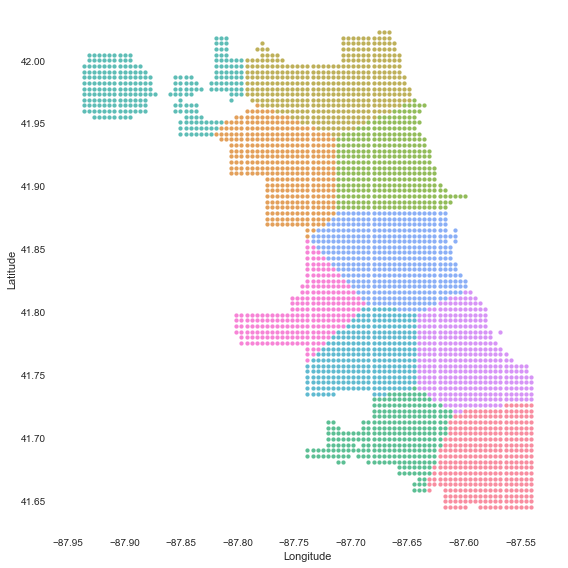

In [33]:
sns.set_style("white")
sns.lmplot(x="Longitude", y="Latitude", data=new_d, fit_reg=False, hue='CLUSTER_LABEL', legend=False, scatter_kws={"s": 18}, size=8)
plt.show()

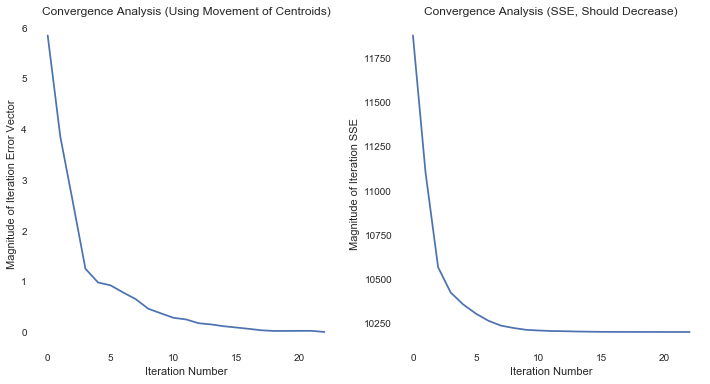

In [34]:
fig, axs = plt.subplots(1,2, figsize=(12,6))
axs[0].plot(range(len(error_mags)), error_mags)
axs[0].set_xlabel('Iteration Number')
axs[0].set_ylabel('Magnitude of Iteration Error Vector')
axs[0].set_title('Convergence Analysis (Using Movement of Centroids)')
axs[1].plot(range(len(sse)), sse)
axs[1].set_xlabel('Iteration Number')
axs[1].set_ylabel('Magnitude of Iteration SSE')
axs[1].set_title('Convergence Analysis (SSE, Should Decrease)')
plt.show()

#### Check EMD and Variance

In [35]:
clustering_grid['SIMPLE_CLUSTER_LABEL'] = [int(i) for i in list(new_d.CLUSTER_LABEL)]
all_c_emd2 = emd(clustering_grid, 'SIMPLE_CLUSTER_LABEL')
print("The average Simple Cluster all crime EMD is: " + str(np.mean(all_c_emd2)) + ", the median is: " + str(np.median(all_c_emd2))  + ", the maximum is: " + str(np.max(all_c_emd2)) + ", and the minimum is: " + str(np.min(all_c_emd2)))
print
print(all_c_emd2)
print
for i in range(10):
    print(len(clustering_grid[clustering_grid.SIMPLE_CLUSTER_LABEL==i]))
print
print('--------------------------------------------------------------')
print
all_c_sd2 = sd(clustering_grid, 'SIMPLE_CLUSTER_LABEL')
print("The average Simple Cluster all crime standard deviation is: " + str(np.mean(all_c_sd2)) + ", the median is: " + str(np.median(all_c_sd2))  + ", the maximum is: " + str(np.max(all_c_sd2)) + ", and the minimum is: " + str(np.min(all_c_sd2)))
print
print(all_c_sd2)
print
for i in range(10):
    print(len(clustering_grid[clustering_grid.SIMPLE_CLUSTER_LABEL==i]))
    

The average Simple Cluster all crime EMD is: 611.114267369, the median is: 639.382401713, the maximum is: 929.263115897, and the minimum is: 135.631774788

[328.30907279153627, 920.6650680616877, 467.7702086581124, 929.2631158967366, 507.35005369450073, 135.63177478771794, 889.0929282507128, 771.4147497311784, 845.0142825904894, 316.6314192295737]

333
350
390
326
264
260
275
409
340
230

--------------------------------------------------------------

The average Simple Cluster all crime standard deviation is: 902.593229177, the median is: 871.631654483, the maximum is: 1743.0468145, and the minimum is: 422.334727465

[468.79344747499897, 1270.6243810643264, 674.4569825874344, 1743.046814495649, 647.1555536281154, 443.76587362224683, 1068.8063263780698, 1142.2976781929742, 1144.6505068636986, 422.3347274647022]

333
350
390
326
264
260
275
409
340
230


##### Consistently sized and relatively consistently large EMDs. Results make sense to me. 

##### Try again quickly with much higher value of k

In [36]:
new_d2, error_mags2, sse2 = pure_geo_k_means(clustering_data, 97, verbose=False)
# Running this showed me that in many cases, the initial error magnitude
new_d2.head()

Done. Total Time: 26.4032020569


,Latitude,Longitude,CLUSTER_LABEL
0,42.022458,-87.675421,30.0
1,42.022458,-87.670930,30.0
2,42.022458,-87.666438,30.0
3,42.017966,-87.819152,70.0
4,42.017966,-87.814660,70.0


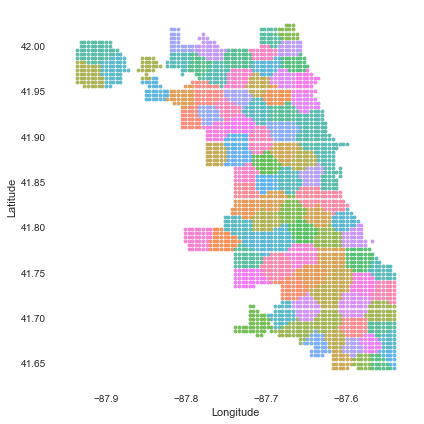

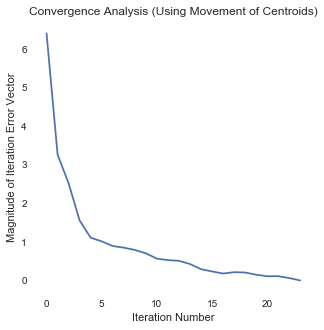

The average Simple Cluster all crime EMD (97 clusters) is: 477.095758727, the median is: 381.524108542, the maximum is: 2847.73408938, and the minimum is: 3.70553074443

-----------------------

The average Simple Cluster all crime standard deviation is: 648.359854658, the median is: 493.436505021, the maximum is: 3984.95498449, and the minimum is: 8.04309380927


In [37]:
sns.set_style("white")
sns.lmplot(x="Longitude", y="Latitude", data=new_d2, fit_reg=False, hue='CLUSTER_LABEL', legend=False, scatter_kws={"s": 15}, size=6)
plt.show()

plt.figure(figsize=(5,5))
plt.plot(range(len(error_mags2)), error_mags2)
plt.xlabel('Iteration Number')
plt.ylabel('Magnitude of Iteration Error Vector')
plt.title('Convergence Analysis (Using Movement of Centroids)')
plt.show()

clustering_grid['SIMPLE_CLUSTER_LABEL_97'] = [int(i) for i in list(new_d2.CLUSTER_LABEL)]
all_c_emd3 = emd(clustering_grid, 'SIMPLE_CLUSTER_LABEL_97')
print("The average Simple Cluster all crime EMD (97 clusters) is: " + str(np.mean(all_c_emd3)) + ", the median is: " + str(np.median(all_c_emd3))  + ", the maximum is: " + str(np.max(all_c_emd3)) + ", and the minimum is: " + str(np.min(all_c_emd3)))
print
print('-----------------------')
print
all_c_sd3 = sd(clustering_grid, 'SIMPLE_CLUSTER_LABEL_97')
print("The average Simple Cluster all crime standard deviation is: " + str(np.mean(all_c_sd3)) + ", the median is: " + str(np.median(all_c_sd3))  + ", the maximum is: " + str(np.max(all_c_sd3)) + ", and the minimum is: " + str(np.min(all_c_sd3)))


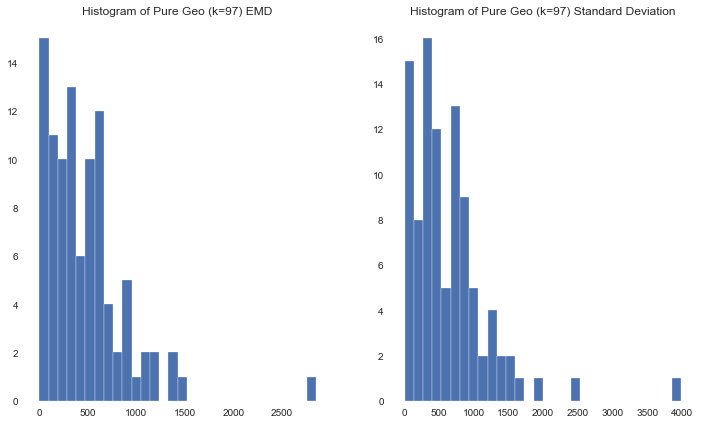

In [38]:
fig, ax = plt.subplots(1,2, figsize=(12,7))
ax[0].hist(all_c_emd3, bins=30)
ax[0].set_title("Histogram of Pure Geo (k=97) EMD")
ax[1].hist(all_c_sd3, bins=30)
ax[1].set_title("Histogram of Pure Geo (k=97) Standard Deviation")
plt.show()

Lower mean but higher median than pre-set neighborhoods for entropy and earth mover's distance with approximately the same number of neighborhoods. We also know that this run has much more evenly sized neighborhoods. So these results make sense. Median says it's a little worse because this method is true random, but mean looks a little bit better because really large neighborhoods don't skew this as far right.  

***
# Model 1 - Crime Vector Clustering - Use Case for Now

### Incorporating features into above geographic clustering algorithm

Clustering together areas geographically, and the additional features that weight the clustering are the crime vector/distribution for each cell. This should be our best possible function, we just have to decide whether to use euclidean distance for these additional factors or use earth mover's distance if we find a useful way to do this. 
***

In [34]:
clustering_data = clustering_grid[['Latitude', 'Longitude', 'All Crime', 'Battery', 'Theft', 'Narcotics']]

def geo_k_means(data, k, alpha = 0.5, cap=1000, verbose=False):
    # pass in data columns that you want to be used for analysis
    # store error for iteration analysis
    error_mags = []
    sse = []
    s1 = time.time()
    
    # initialize centroids
    rand_inds = random.sample(range(0, len(data)), k)
    arr = data.iloc[rand_inds]
    centroids_curr = np.array(arr, dtype=np.float32)
    
    # centroid storage
    centroids_old = np.zeros((k,2))
    # cluster label
    clusters = np.zeros(len(data))
    ideal_error = list(np.zeros(k))
    error = []
    for i in range(k):
        # lats and lons for haversine distance
        error.append(hav_dist(centroids_old[i][0], centroids_old[i][1], centroids_curr[i][0], centroids_curr[i][1]))
    itera = 0
    while not error == ideal_error:
        s2 = time.time()
        itera += 1
        
        # stop early
        if itera > cap:
            break
        
        if verbose:
            print("Iteration: " + str(itera))
        for i in range(len(data)):
            
            distances = []
            lat = data.at[i, 'Latitude']
            lon = data.at[i, 'Longitude']
            all_c = data.at[i, 'All Crime']
            batt = data.at[i, 'Battery']
            theft = data.at[i, 'Theft']
            narc = data.at[i, 'Narcotics']
            for j in range(len(centroids_curr)):
                hav = hav_dist(centroids_curr[j][0], centroids_curr[j][1], lat, lon)
                curr = np.array([all_c, batt, theft, narc])
                cent = np.array([centroids_curr[j][2],centroids_curr[j][3],centroids_curr[j][4],centroids_curr[j][5]])
                vec_dis = np.linalg.norm(curr-cent)
                distances.append((1.0-alpha) * hav + (alpha) * vec_dis)
            cluster_num = np.argmin(distances)
            clusters[i] = cluster_num
        # Store old centroid values
        C_old_store = deepcopy(centroids_curr)
        count_duds = 0
        data.temp_clust = clusters

        sse_iter = 0
        for i in range(k):
            points_in_clust = data[data.temp_clust == i][['Latitude','Longitude','All Crime','Battery','Theft','Narcotics']]
            if len(points_in_clust) > 0:
                centroids_curr[i] = np.mean(points_in_clust, axis=0)
            else:
                count_duds += 1
                rand_ind = random.sample(range(0, len(data)), 1)
                arr = data.iloc[rand_ind]
                centroids_curr[i] = np.array(arr, dtype=np.float32)
            mean = centroids_curr[i]
            lat = mean[0]
            lon = mean[1]
            mean_feat = mean[2:]
            
            matrix = np.array(points_in_clust)
            lats = matrix[:,0]
            lons = matrix[:,1]
            feats = matrix[:,2:]
            
            for j in range(len(matrix)):
                sse_iter = sse_iter + (1.0-alpha)*hav_dist(lat, lon, lats[j], lons[j]) + alpha*np.linalg.norm(mean_feat-feats[j])
        sse.append(sse_iter)
        error = []
        for i in range(k):
            hav = hav_dist(C_old_store[i][0], C_old_store[i][1], centroids_curr[i][0], centroids_curr[i][1])
            v1 = np.array([C_old_store[i][2], C_old_store[i][3], C_old_store[i][4], C_old_store[i][5]])
            v2 = np.array([centroids_curr[i][2], centroids_curr[i][3], centroids_curr[i][4], centroids_curr[i][5]])
            vec = np.linalg.norm(v1-v2)
            error.append(10.0 * hav + 1.0 * vec)
        er = np.linalg.norm(error)
        if verbose:
            print("Magnitude of error: " + str(er))
            print("Iteration took: " + str(time.time()-s2))
            print("Number of issues: " + str(count_duds))
            print
        error_mags.append(er)
    print("Done, Successful Convergence. Total Time: " + str(time.time() - s1))
    data['CLUSTER_LABEL'] = clusters
    return data, error_mags, sse


In [35]:
new_d5, error_mags5, sse5 = geo_k_means(clustering_data, 97, cap=80, verbose=True)

Iteration: 1
Magnitude of error: 1641.38970058
Iteration took: 5.25854897499
Number of issues: 0

Iteration: 2
Magnitude of error: 1065.06664559
Iteration took: 5.15887498856
Number of issues: 0

Iteration: 3
Magnitude of error: 809.492296018
Iteration took: 6.96941804886
Number of issues: 0

Iteration: 4
Magnitude of error: 1104.36513297
Iteration took: 9.96436595917
Number of issues: 0

Iteration: 5
Magnitude of error: 1779.38611592
Iteration took: 13.2355318069
Number of issues: 0

Iteration: 6
Magnitude of error: 2999.13067608
Iteration took: 8.82563495636
Number of issues: 0

Iteration: 7
Magnitude of error: 3613.00101467
Iteration took: 5.75837993622
Number of issues: 0

Iteration: 8
Magnitude of error: 510.499085856
Iteration took: 5.55712389946
Number of issues: 0

Iteration: 9
Magnitude of error: 662.991259624
Iteration took: 5.52698397636
Number of issues: 0

Iteration: 10
Magnitude of error: 377.41790244
Iteration took: 5.55255103111
Number of issues: 0

Iteration: 11
Magnit

<Figure size 720x1008 with 0 Axes>

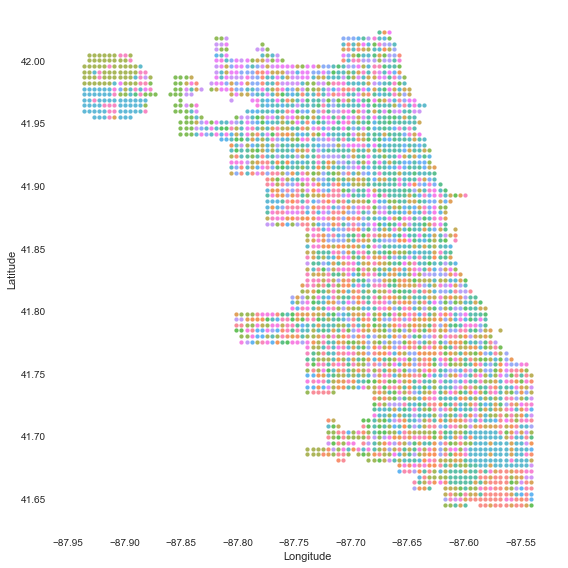

In [36]:
plt.figure(figsize=(10,14))
sns.lmplot(x="Longitude", y="Latitude", data=new_d5, fit_reg=False, hue='CLUSTER_LABEL', legend=False, scatter_kws={"s": 18}, size=8)
plt.show()

The average Simple Cluster all crime EMD is: 63.9652292879, the median is: 5.59524061305, the maximum is: 2601.37444256, and the minimum is: 0.531080438129

----------------------------------------------------------------------------

The average Simple Cluster all crime Standard Deviation is: 94.6243590594, the median is: 19.9785599367, the maximum is: 3467.82312842, and the minimum is: 1.11306768329



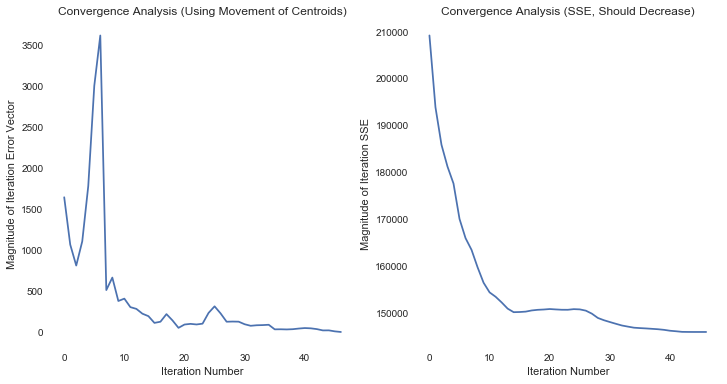

In [37]:
clustering_grid['FEATURE_CLUSTER_LABEL'] = [int(i) for i in list(new_d5.CLUSTER_LABEL)]
all_c_emd4 = emd(clustering_grid, 'FEATURE_CLUSTER_LABEL')
print("The average Simple Cluster all crime EMD is: " + str(np.mean(all_c_emd4)) + ", the median is: " + str(np.median(all_c_emd4)) + ", the maximum is: " + str(np.max(all_c_emd4)) + ", and the minimum is: " + str(np.min(all_c_emd4)))
print
print('----------------------------------------------------------------------------')
print
all_c_sd4 = sd(clustering_grid, 'FEATURE_CLUSTER_LABEL')
print("The average Simple Cluster all crime Standard Deviation is: " + str(np.mean(all_c_sd4)) + ", the median is: " + str(np.median(all_c_sd4))  + ", the maximum is: " + str(np.max(all_c_sd4)) + ", and the minimum is: " + str(np.min(all_c_sd4)))
print
fig, axs = plt.subplots(1,2, figsize=(12,6))
axs[0].plot(range(len(error_mags5)), error_mags5)
axs[0].set_xlabel('Iteration Number')
axs[0].set_ylabel('Magnitude of Iteration Error Vector')
axs[0].set_title('Convergence Analysis (Using Movement of Centroids)')
axs[1].plot(range(len(sse5)), sse5)
axs[1].set_xlabel('Iteration Number')
axs[1].set_ylabel('Magnitude of Iteration SSE')
axs[1].set_title('Convergence Analysis (SSE, Should Decrease)')
plt.show()

#### Analyzing these results (on 97 clusters, same as Neighborhood baseline):

Great results, super homogeneous! Standard Deviation doesn't show the difference as well, although it looks decent, but EMD really shows how good this "optimal" model is, even though it really doesn't represent neighborhoods. This is what we want to see because it really should prioritize clustering areas with similar crime data, thus crime homogeneity.

***
# Normalize data before running 'geo_k_means'

#### Attempt 1: Normalize Everything
***

In [38]:
data_for_norm = deepcopy(clustering_data)[['Latitude', 'Longitude', 'All Crime', 'Battery', 'Theft', 'Narcotics']]
normalized_clustering_data = (data_for_norm-data_for_norm.mean())/data_for_norm.std()[['Latitude', 'Longitude', 'All Crime', 'Battery', 'Theft', 'Narcotics']]
new_d7, error_mags7, sse7 = geo_k_means(normalized_clustering_data, 97, cap=1000, verbose=True)

Iteration: 1
Magnitude of error: 927.547439918
Iteration took: 5.76283288002
Number of issues: 0

Iteration: 2
Magnitude of error: 411.356629431
Iteration took: 5.98428487778
Number of issues: 0

Iteration: 3
Magnitude of error: 250.841662453
Iteration took: 5.0364010334
Number of issues: 0

Iteration: 4
Magnitude of error: 185.684577589
Iteration took: 5.0399711132
Number of issues: 0

Iteration: 5
Magnitude of error: 144.285982958
Iteration took: 5.00073504448
Number of issues: 0

Iteration: 6
Magnitude of error: 127.0770752
Iteration took: 5.0178129673
Number of issues: 0

Iteration: 7
Magnitude of error: 106.628702965
Iteration took: 5.03408193588
Number of issues: 0

Iteration: 8
Magnitude of error: 93.3083316938
Iteration took: 4.99924206734
Number of issues: 0

Iteration: 9
Magnitude of error: 77.6178798516
Iteration took: 5.16269493103
Number of issues: 0

Iteration: 10
Magnitude of error: 76.8708402372
Iteration took: 5.0225789547
Number of issues: 0

Iteration: 11
Magnitude o

<Figure size 720x1008 with 0 Axes>

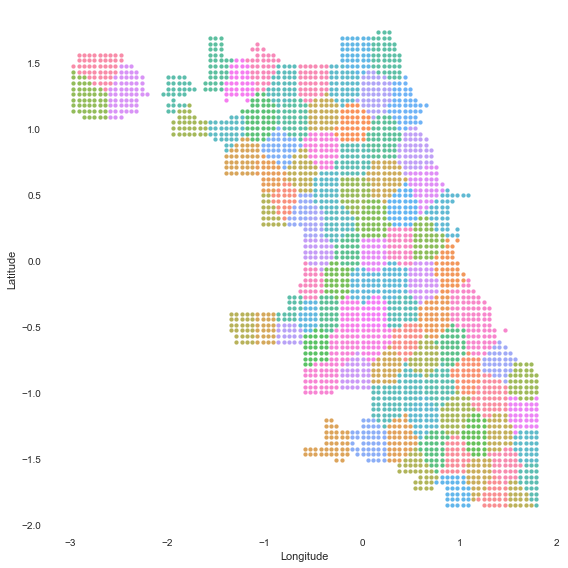

The average Simple Cluster all crime EMD is: 470.050882261, the median is: 370.767766703, the maximum is: 2550.88110943, and the minimum is: 2.24997849999

-----------------------------------------------------

The average Simple Cluster all crime Standard Deviation is: 642.321486369, the median is: 488.617457817, the maximum is: 3921.59453713, and the minimum is: 5.00208289949



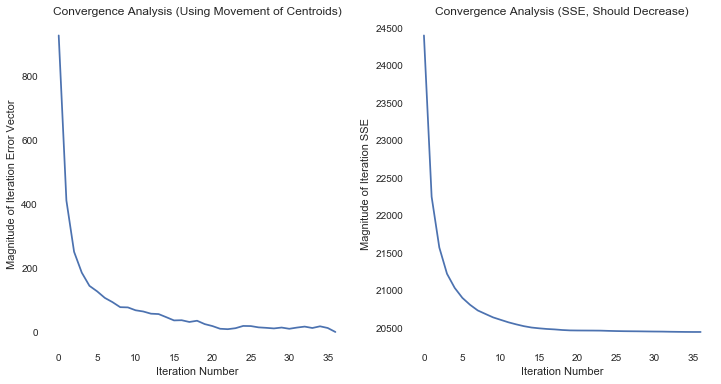

In [39]:
# EVALUATE MODEL
plt.figure(figsize=(10,14))
sns.lmplot(x="Longitude", y="Latitude", data=new_d7, fit_reg=False, hue='CLUSTER_LABEL', legend=False, scatter_kws={"s": 18}, size=8)
plt.show()

clustering_grid['NORM_FEATURE_CLUSTER_LABEL'] = [int(i) for i in list(new_d7.CLUSTER_LABEL)]
all_c_emd5 = emd(clustering_grid, 'NORM_FEATURE_CLUSTER_LABEL')
all_c_sd5 = sd(clustering_grid, 'NORM_FEATURE_CLUSTER_LABEL')
print("The average Simple Cluster all crime EMD is: " + str(np.mean(all_c_emd5)) + ", the median is: " + str(np.median(all_c_emd5)) + ", the maximum is: " + str(np.max(all_c_emd5)) + ", and the minimum is: " + str(np.min(all_c_emd5)))
print
print('-----------------------------------------------------')
print
print("The average Simple Cluster all crime Standard Deviation is: " + str(np.mean(all_c_sd5)) + ", the median is: " + str(np.median(all_c_sd5)) + ", the maximum is: " + str(np.max(all_c_sd5)) + ", and the minimum is: " + str(np.min(all_c_sd5)))
print
fig, axs = plt.subplots(1,2, figsize=(12,6))
axs[0].plot(range(len(error_mags7)), error_mags7)
axs[0].set_xlabel('Iteration Number')
axs[0].set_ylabel('Magnitude of Iteration Error Vector')
axs[0].set_title('Convergence Analysis (Using Movement of Centroids)')
axs[1].plot(range(len(sse7)), sse7)
axs[1].set_xlabel('Iteration Number')
axs[1].set_ylabel('Magnitude of Iteration SSE')
axs[1].set_title('Convergence Analysis (SSE, Should Decrease)')
plt.show()


#### Attempt 2: Normalize all but Lat and Lon

In [40]:
data_for_norm = deepcopy(clustering_data)[['Latitude', 'Longitude', 'All Crime', 'Battery', 'Theft', 'Narcotics']]

for col in ['All Crime', 'Battery', 'Theft', 'Narcotics']:
    data_for_norm[col] = (data_for_norm[col]-data_for_norm[col].mean())/data_for_norm[col].std()
new_d8, error_mags8, sse8 = geo_k_means(data_for_norm, 97, cap=40, verbose=True)

Iteration: 1
Magnitude of error: 80.0229696562
Iteration took: 4.92962694168
Number of issues: 0

Iteration: 2
Magnitude of error: 36.2967185043
Iteration took: 4.98300600052
Number of issues: 0

Iteration: 3
Magnitude of error: 28.749008592
Iteration took: 4.95973205566
Number of issues: 0

Iteration: 4
Magnitude of error: 24.7083562618
Iteration took: 5.1983101368
Number of issues: 0

Iteration: 5
Magnitude of error: 21.1088566366
Iteration took: 4.98076987267
Number of issues: 0

Iteration: 6
Magnitude of error: 17.6711711721
Iteration took: 5.15567803383
Number of issues: 0

Iteration: 7
Magnitude of error: 15.5895122149
Iteration took: 5.21373987198
Number of issues: 0

Iteration: 8
Magnitude of error: 14.8964627038
Iteration took: 5.00319695473
Number of issues: 0

Iteration: 9
Magnitude of error: 17.5422160399
Iteration took: 5.20447301865
Number of issues: 0

Iteration: 10
Magnitude of error: 11.2288145367
Iteration took: 5.0045800209
Number of issues: 0

Iteration: 11
Magnitud

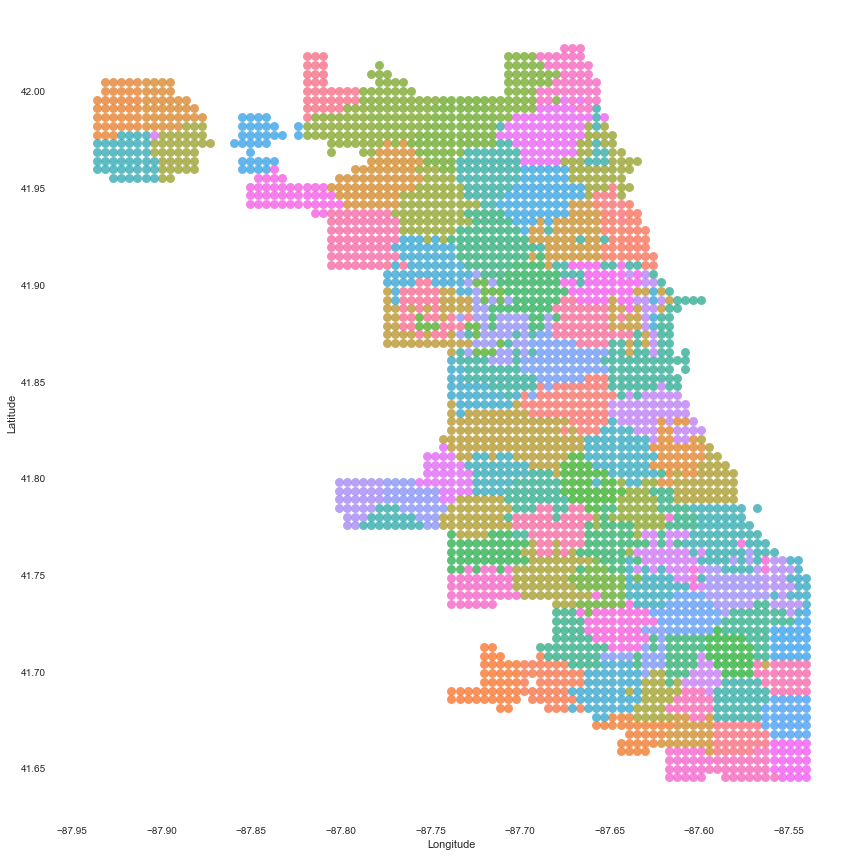

The average Simple Cluster all crime EMD is: 336.081532328, the median is: 298.520180962, the maximum is: 2601.37444256, and the minimum is: 1.02580606451

-----------------------------------------------------

The average Simple Cluster all crime Standard Deviation is: 451.827980667, the median is: 391.110967955, the maximum is: 3467.82312842, and the minimum is: 0.0



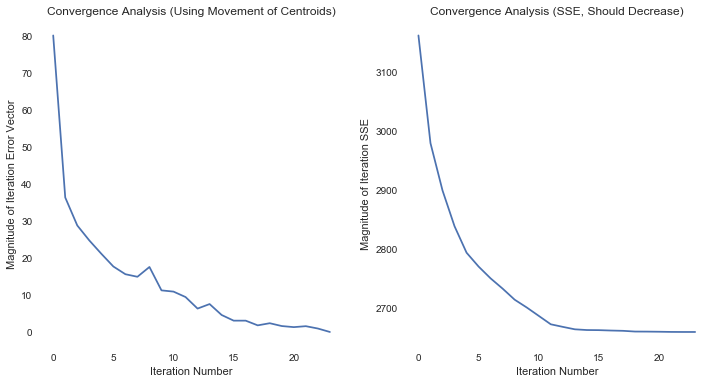

In [41]:
# EVALUATE MODEL
sns.lmplot(x="Longitude", y="Latitude", data=new_d8, fit_reg=False, hue='CLUSTER_LABEL', legend=False, scatter_kws={"s": 80}, size=12)
plt.show()

clustering_grid['SEMI_NORM_FEATURE_CLUSTER_LABEL'] = [int(i) for i in list(new_d8.CLUSTER_LABEL)]
all_c_emd6 = emd(clustering_grid, 'SEMI_NORM_FEATURE_CLUSTER_LABEL')
all_c_sd6 = sd(clustering_grid, 'SEMI_NORM_FEATURE_CLUSTER_LABEL')
print("The average Simple Cluster all crime EMD is: " + str(np.mean(all_c_emd6)) + ", the median is: " + str(np.median(all_c_emd6)) + ", the maximum is: " + str(np.max(all_c_emd6)) + ", and the minimum is: " + str(np.min(all_c_emd6)))
print
print('-----------------------------------------------------')
print
print("The average Simple Cluster all crime Standard Deviation is: " + str(np.mean(all_c_sd6)) + ", the median is: " + str(np.median(all_c_sd6)) + ", the maximum is: " + str(np.max(all_c_sd6)) + ", and the minimum is: " + str(np.min(all_c_sd6)))
print
fig, axs = plt.subplots(1,2, figsize=(12,6))
axs[0].plot(range(len(error_mags8)), error_mags8)
axs[0].set_xlabel('Iteration Number')
axs[0].set_ylabel('Magnitude of Iteration Error Vector')
axs[0].set_title('Convergence Analysis (Using Movement of Centroids)')
axs[1].plot(range(len(sse8)), sse8)
axs[1].set_xlabel('Iteration Number')
axs[1].set_ylabel('Magnitude of Iteration SSE')
axs[1].set_title('Convergence Analysis (SSE, Should Decrease)')
plt.show()


It's interesting. EMD looks considerably better for this model, entropy looks pretty bad. Not exactly sure why this is, but I think it makes sense that the result should be more homogeneous than the baseline because it considers the data. It's starting to seem like there is overwhelming evidence that EMD is a better metric of homogeneity (and it is a topic people will want to see in writing)

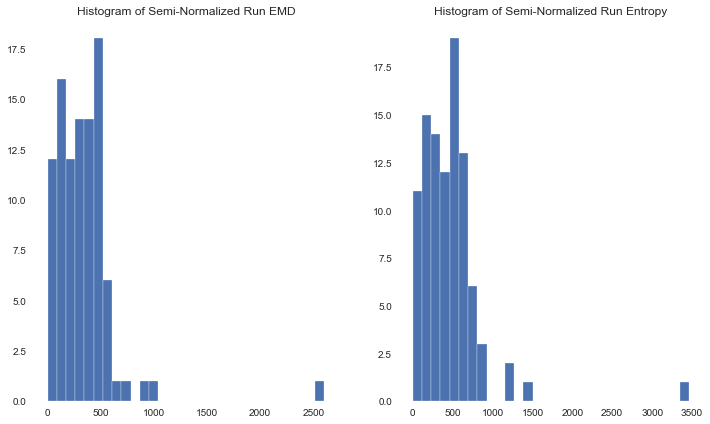

In [42]:
fig, ax = plt.subplots(1,2, figsize=(12,7))
ax[0].hist(all_c_emd6, bins=30)
ax[0].set_title("Histogram of Semi-Normalized Run EMD")
ax[1].hist(all_c_sd6, bins=30)
ax[1].set_title("Histogram of Semi-Normalized Run Entropy")
plt.show()

#### Analysis of these models:

As noted by the fact that model 2 is run, model 1 doesn't really make sense because haversine distance is specifically for lat/lon, not for a transformed variable. Model 2 is tricky because it doesn't weight hav distance and vector distance properly but it doesn't blatantly handle distance incorrectly. Visually, it actually looks pretty solid because it clearly considers the data and warps neighborhood boundaries, but they still look reasonably like neighborhood boundaries in. Once we tune alpha, this will look better.

***
# Introduce a Regularization Parameter (probably needs more work)
***

#### Research on Regularization to write up:

We could count the number of distinct regions. Number of disjoint regions

For each cell, we can count up how many neighboring cells are in the same neighborhood and add up total number of non-neighbor relationships. 

An internal neighborhood cell contributes 0

A regular border cell contibutes 3 (center one)

XXX
OOO
OOO

Contributing 4

XXX
OOX
OOO

And so on...

A completely isolated cell contribues 8

XXX
XOX
XXX

Logically, this seems to satisfy the conditions that we want to penalize. Jaggedness and isolation especially


In [43]:
def regularize(data, cluster_col):
    
    s = time.time()
    lats = set(list(data.Latitude))
    lons = set(list(data.Longitude))
    
    #total_existing = 0
    total_reg_penalty = 0
    #failures = 0
    
    for index, row in data.iterrows():
        
        lat = row.Latitude
        lon = row.Longitude
        nei_identity = row[cluster_col]
        
        s1 = time.time()
        
        try:
            lat_above = np.min([i for i in lats if i > lat])
        except:
            #failures = failures + 1
            lat_above = 0.0
        try:
            lat_below = np.max([i for i in lats if i < lat])
        except:
            #failures = failures + 1
            lat_below = 0.0
        try:
            lon_above = np.min([i for i in lons if i > lon])
        except:
            #failures = failures + 1
            lon_above = 0.0
        try:
            lon_below = np.max([i for i in lons if i < lon])
        except:
            #failures = failures + 1
            lon_below = 0.0
            
        s2 = time.time()
        
        lat_list = [i for i in [lat, lat_above, lat_below] if i != 0.0]
        lon_list = [i for i in [lon, lon_above, lon_below] if i != 0.0]
        
        for latitude in lat_list:
            lat_cut = data[data.Latitude == latitude]
            for longitude in lon_list:
                #allegiance = data.loc[(data.Latitude == latitude) & (data.Longitude == longitude)][cluster_col]
                lon_cut = lat_cut[lat_cut.Longitude == longitude]
                allegiance = list(lon_cut[cluster_col])
                
                if len(allegiance) == 1:
                    #total_existing = total_existing + 1
                    if not allegiance[0] == nei_identity:
                        total_reg_penalty = total_reg_penalty + 1
        
        s3 = time.time()
        
    print("Total time: " + str(time.time() - s))
    print("Regularization Penalty: " + str(total_reg_penalty))
        
    return total_reg_penalty

Test: Beats should probably be greater than neighborhoods because there are so many different areas. It seems to work! Regularization takes longer than we want (~20-25 seconds for each run), but this probably won't be prohibitive.

In [44]:
print("Running for 97 Neighborhoods")
nei_reg = regularize(clustering_grid, 'Neighborhoods')
print
print("Running for 260+ Beats")
beat_reg = regularize(clustering_grid, 'Beats')

Running for 97 Neighborhoods
Total time: 34.5646440983
Regularization Penalty: 5442

Running for 260+ Beats
Total time: 37.1318120956
Regularization Penalty: 8982


***
# Set up elbow plot and silhouette plot

### First on one run
***

#### Silhouette Method

The silhouette measures the difference between the dissimilarity between observation $i$ and other points in the next clostest cluster and other points in the cluster in which $i$ belongs to. Here we look at the average silhouette statistic across clusters. It is intuitive that we want to *maximize* this value. 

For this example, we will stick with calculating distance as Euclidean distance for simplicity and for the sake of run time. Given what we have seen in comparing euclidean distance to Haversine distance, this should still be useful.

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html


Neighborhood silhouette analysis
For n_clusters=97 The average silhouette_score is: -0.585891711669


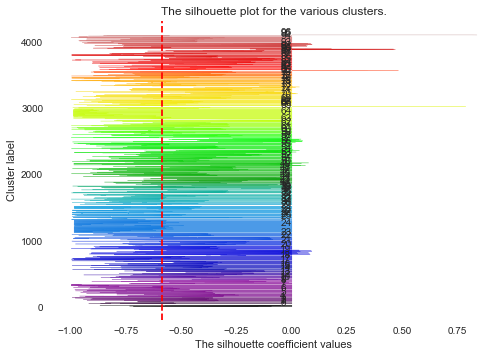


For a better previously run model
For n_clusters=97 The average silhouette_score is: -0.481061218893


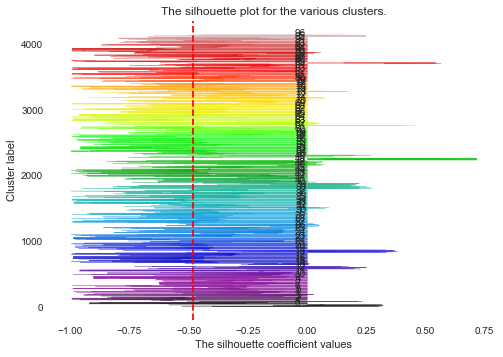


For a totally unrealistic but highly homogeneous model
For n_clusters=97 The average silhouette_score is: 0.139616251446


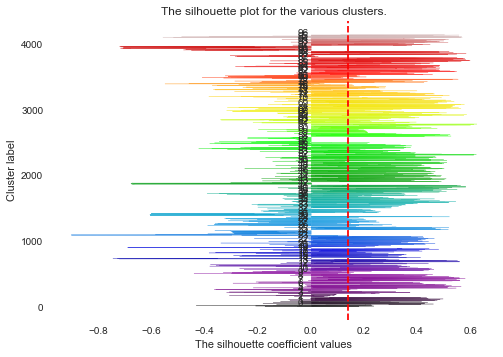

0.13961625144620235

In [45]:

def silhouette(data, cluster_col, n_clusters):
    cols = ['Latitude', 'Longitude', 'All Crime', 'Battery', 'Assault', 'Theft']
    X = data[cols]
    cluster_labels = data[cluster_col]
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters=" + str(n_clusters) + " The average silhouette_score is: "+ str(silhouette_avg))
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    
    fig, ax1 = plt.subplots(1, 1)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.show()
    
    return silhouette_avg
    
print("Neighborhood silhouette analysis")
silhouette(clustering_grid, 'Neighborhoods', 97)
print
print("For a better previously run model")
silhouette(clustering_grid, 'SEMI_NORM_FEATURE_CLUSTER_LABEL', 97)
print
print("For a totally unrealistic but highly homogeneous model")
silhouette(clustering_grid, 'FEATURE_CLUSTER_LABEL', 97)


*Analysis*: This seems to get into our question abnout optimal value of alpha for weighting features vs. geography but could be a good way to compare k values when we hold alpha constant.

#### Gap Statistic

The gap statistic compares the total within intra-cluster variation for different values of k with their expected values under null reference distribution of the data. The estimate of the optimal clusters will be value that maximize the gap statistic (i.e, that yields the largest gap statistic). This means that the clustering structure is far away from the random uniform distribution of points.

Python Implementation: 

https://snippets.cacher.io/snippet/992c45f7b11bacc5e862

If I implement it myself, go off this: https://www.datanovia.com/en/lessons/determining-the-optimal-number-of-clusters-3-must-know-methods/#gap-statistic-method but I am confused about what it means by generate a uniform random distribution.

In [46]:
# TODO? #

### Run on Lots of K Values

Done, Successful Convergence. Total Time: 4.86850214005


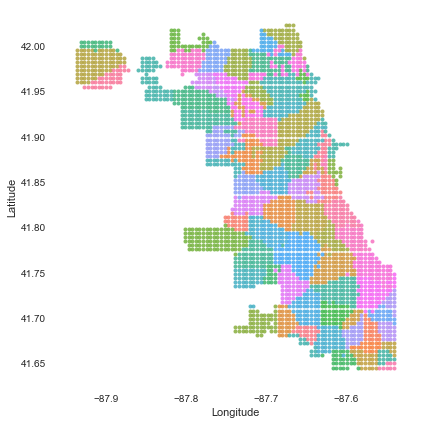

Total time: 39.3495070934
Regularization Penalty: 5868
For n_clusters=80 The average silhouette_score is: -0.546881310431


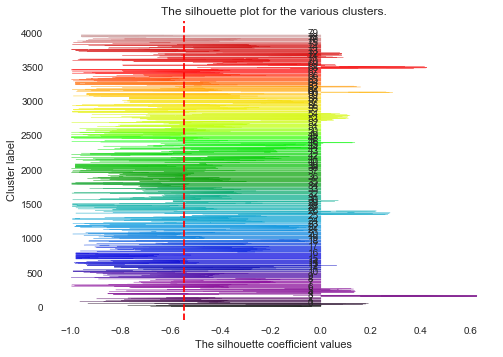

K Value: 80, median EMD: 292.449317182

Done, Successful Convergence. Total Time: 8.37016510963


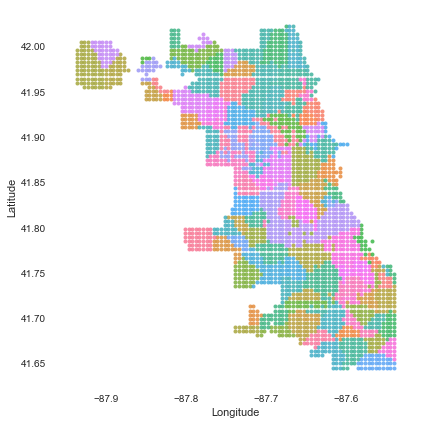

Total time: 41.5889620781
Regularization Penalty: 7222
For n_clusters=120 The average silhouette_score is: -0.567782636517


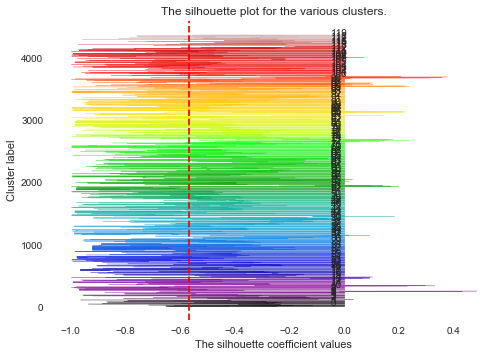

K Value: 120, median EMD: 322.038363466



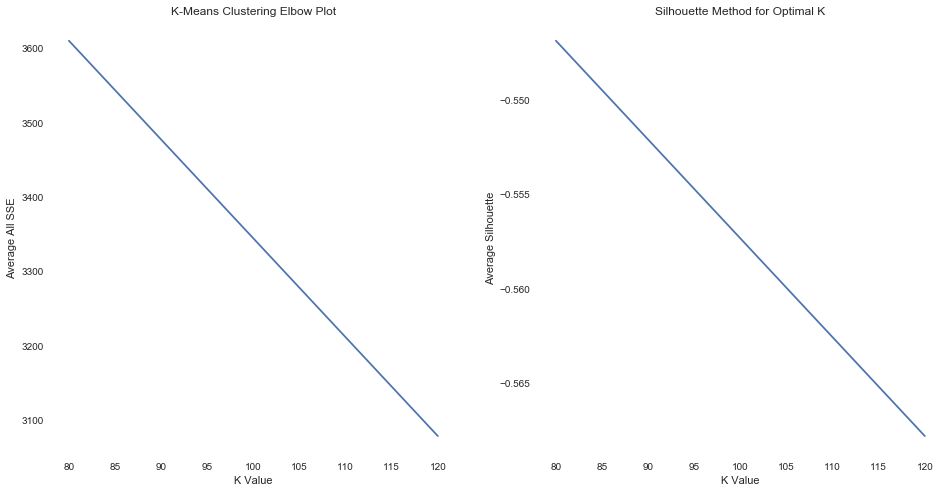

In [47]:
k_list = [80, 120]#[80, 85, 90, 95, 100, 105, 110, 115, 120]

data_for_norm3 = deepcopy(clustering_data)[['Latitude', 'Longitude', 'All Crime', 'Battery', 'Theft', 'Narcotics']]
for col in ['All Crime', 'Battery', 'Theft', 'Narcotics']:
    data_for_norm3[col] = (data_for_norm3[col]-data_for_norm3[col].mean())/data_for_norm3[col].std()
#clustering_data = clustering_grid[['Latitude', 'Longitude', 'All Crime', 'Battery', 'Theft', 'Narcotics']]

sd_list_3 = []
emd_list_3 = []
reg_pen_list_3 = []
final_sse = []
silhouettes = []

for k_val in k_list:
    
    df, error, sse = geo_k_means(data_for_norm3[['Latitude', 'Longitude', 'All Crime', 'Battery', 'Theft', 'Narcotics']], k=k_val, alpha=0.3, cap=1,verbose=False)
    #df, error = pure_geo_k_means_capped(clustering_data[['Latitude', 'Longitude', 'All Crime', 'Battery', 'Theft', 'Narcotics']], k_val, 15)
    str_lab = "Cluster_Label_K_" + str(k_val)
    clustering_grid[str_lab] = [int(i) for i in list(df.CLUSTER_LABEL)]
    
    sns.lmplot(x="Longitude", y="Latitude", data=clustering_grid, fit_reg=False, hue=str_lab, legend=False, scatter_kws={"s": 16}, size=6)
    plt.show()
    
    reg_pen3 = regularize(clustering_grid, str_lab)
    reg_pen_list_3.append(reg_pen3)
    final_sse.append(sse[len(sse)-1])
    
    all_c_emd = emd(clustering_grid, str_lab)
    emd_list_3.append(np.median(all_c_emd))
    all_c_sd = sd(clustering_grid, str_lab)
    sd_list_3.append(np.median(all_c_sd))
    sil_val = silhouette(clustering_grid, str_lab, k_val)
    silhouettes.append(sil_val)
    print("K Value: " + str(k_val) + ", median EMD: " + str(np.median(all_c_emd)))
    print
    
fig, axs = plt.subplots(1,2, figsize=(16,8))
axs[0].plot(k_list, final_sse)
#Regularization = plt.plot(k_list, [x for x in reg_pen_list_3])
axs[0].set_xlabel("K Value")
axs[0].set_ylabel("Average All SSE")
axs[0].set_title("K-Means Clustering Elbow Plot")
axs[1].plot(k_list, silhouettes)
axs[1].set_xlabel("K Value")
axs[1].set_ylabel("Average Silhouette")
axs[1].set_title("Silhouette Method for Optimal K")
plt.show()

In [48]:
print(silhouettes)

[-0.54688131043123545, -0.56778263651705763]


In [49]:
def optimal_k_run(alpha):
    k_list = [80, 85, 90, 95, 100, 105, 110, 115, 120]

    data_for_norm3 = deepcopy(clustering_data)[['Latitude', 'Longitude', 'All Crime', 'Battery', 'Theft', 'Narcotics']]
    for col in ['All Crime', 'Battery', 'Theft', 'Narcotics']:
        data_for_norm3[col] = (data_for_norm3[col]-data_for_norm3[col].mean())/data_for_norm3[col].std()
    #clustering_data = clustering_grid[['Latitude', 'Longitude', 'All Crime', 'Battery', 'Theft', 'Narcotics']]

    sd_list_3 = []
    emd_list_3 = []
    reg_pen_list_3 = []
    final_sse = []
    silhouettes = []

    for k_val in k_list:
    
        df, error, sse = geo_k_means(data_for_norm3[['Latitude', 'Longitude', 'All Crime', 'Battery', 'Theft', 'Narcotics']], k=k_val, alpha=alpha, cap=1000,verbose=False)
        #df, error = pure_geo_k_means_capped(clustering_data[['Latitude', 'Longitude', 'All Crime', 'Battery', 'Theft', 'Narcotics']], k_val, 15)
        str_lab = "Cluster_Label_K_" + str(k_val)
        clustering_grid[str_lab] = [int(i) for i in list(df.CLUSTER_LABEL)]
    
        sns.lmplot(x="Longitude", y="Latitude", data=clustering_grid, fit_reg=False, hue=str_lab, legend=False, scatter_kws={"s": 16}, size=6)
        plt.show()
    
        reg_pen3 = regularize(clustering_grid, str_lab)
        reg_pen_list_3.append(reg_pen3)
        final_sse.append(sse[len(sse)-1])
    
        all_c_emd = emd(clustering_grid, str_lab)
        emd_list_3.append(np.median(all_c_emd))
        all_c_sd = sd(clustering_grid, str_lab)
        sd_list_3.append(np.median(all_c_sd))
        sil_val = silhouette(clustering_grid, str_lab, k_val)
        silhouettes.append(sil_val)
        print("K Value: " + str(k_val) + ", median EMD: " + str(np.median(all_c_emd)))
        print
    
    fig, axs = plt.subplots(1,2, figsize=(16,8))
    axs[0].plot(k_list, final_sse)
    #Regularization = plt.plot(k_list, [x for x in reg_pen_list_3])
    axs[0].set_xlabel("K Value")
    axs[0].set_ylabel("Average All SSE")
    axs[0].set_title("K-Means Clustering Elbow Plot")
    axs[1].plot(k_list, silhouettes)
    axs[1].set_xlabel("K Value")
    axs[1].set_ylabel("Average Silhouette")
    axs[1].set_title("Silhouette Method for Optimal K")
    plt.show()
    

### Big run to find optimal K for each alpha!

### NOTE: Takes a while to Run- Don't Re-run if Avoidable !!!

In [ ]:
alphas = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]

for alp in alphas:
    print("RUNNING NOW FOR ALPHA=" + str(alp))
    optimal_k_run(alp)

#### Results from above:

<img src="Files/0.01.png" width="700">

Alpha = 0.01, k = 105?

***

<img src="Files/0.1.png" width="700">

Alpha = 0.1, k = 110

***

<img src="Files/0.2.png" width="700">

Alpha = 0.2, k = 100

***

<img src="Files/0.3.png" width="700">

Alpha = 0.3, k = 90

***

<img src="Files/0.4.png" width="700">

Alpha = 0.4, k = 100

***

<img src="Files/0.5.png" width="700">

Alpha = 0.5, k = 85

***

<img src="Files/0.6.png" width="700">

Alpha = 0.6, k = 90

***

<img src="Files/0.7.png" width="700">

Alpha = 0.7, k = 85

***

<img src="Files/0.8.png" width="700">

Alpha = 0.8, k = 100

***

<img src="Files/0.9.png" width="700">

Alpha = 0.9, k = 85

***

<img src="Files/0.99.png" width="700">

Alpha = 0.99, k = 95



Done, Successful Convergence. Total Time: 211.919672012


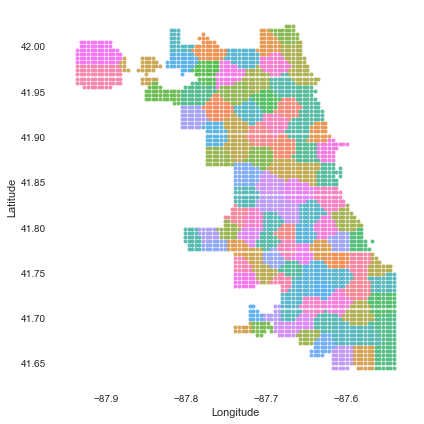

Total time: 35.0184369087
Regularization Penalty: 5330
Alpha: 0.01, K: 105, median EMD: 343.460218847

Done, Successful Convergence. Total Time: 133.848412037


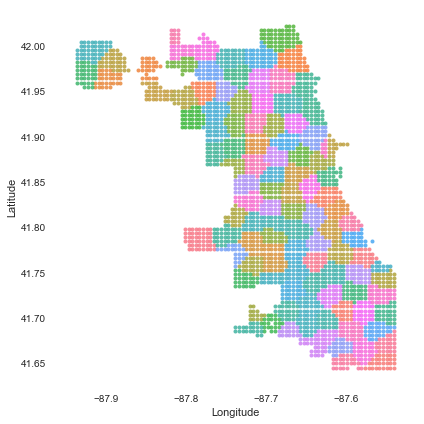

Total time: 32.2431721687
Regularization Penalty: 5584
Alpha: 0.1, K: 110, median EMD: 374.417887824

Done, Successful Convergence. Total Time: 155.044561148


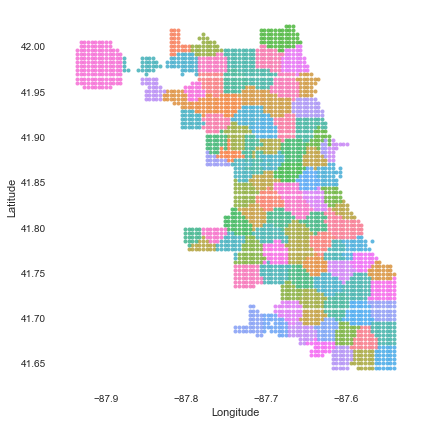

Total time: 34.8374559879
Regularization Penalty: 5418
Alpha: 0.2, K: 100, median EMD: 365.389694177

Done, Successful Convergence. Total Time: 131.077521801


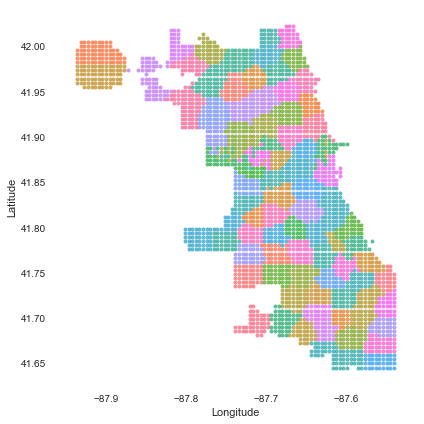

Total time: 35.2909860611
Regularization Penalty: 5452
Alpha: 0.3, K: 90, median EMD: 360.369201135

Done, Successful Convergence. Total Time: 211.585945845


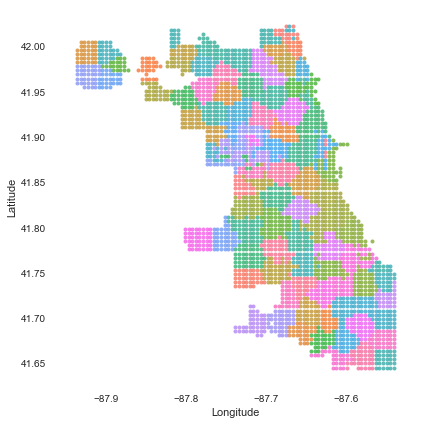

Total time: 33.3462049961
Regularization Penalty: 6210
Alpha: 0.4, K: 100, median EMD: 325.933825078

Done, Successful Convergence. Total Time: 194.178153038


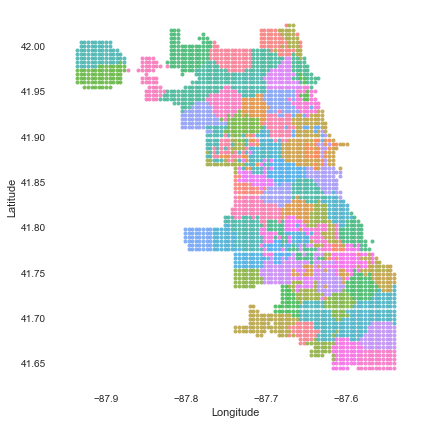

Total time: 45.7743258476
Regularization Penalty: 6740
Alpha: 0.5, K: 85, median EMD: 294.865953482

Done, Successful Convergence. Total Time: 313.74920392


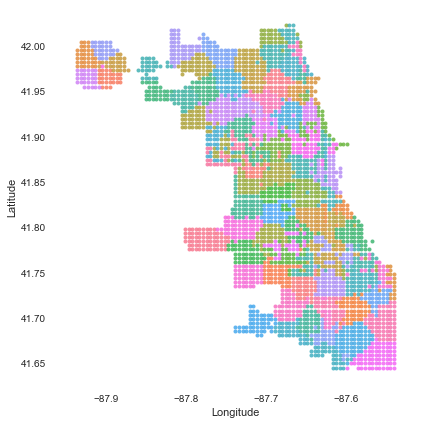

Total time: 229.878247023
Regularization Penalty: 7604
Alpha: 0.6, K: 90, median EMD: 275.813501478

Done, Successful Convergence. Total Time: 276.488598824


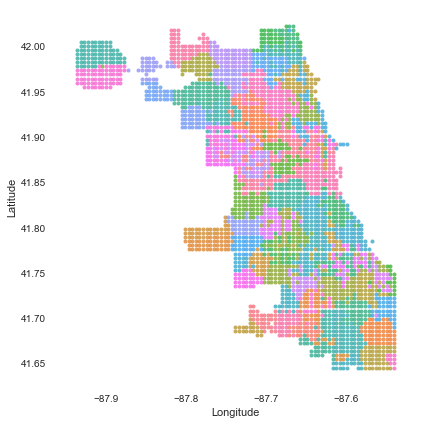

Total time: 28.8213670254
Regularization Penalty: 9012
Alpha: 0.7, K: 85, median EMD: 226.494434436

Done, Successful Convergence. Total Time: 480.233686209


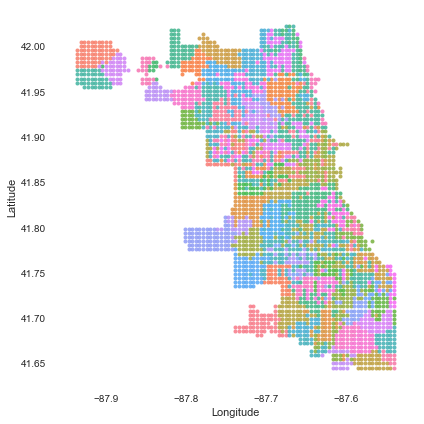

Total time: 29.7648091316
Regularization Penalty: 11456
Alpha: 0.8, K: 100, median EMD: 160.175118608

Done, Successful Convergence. Total Time: 170.068480015


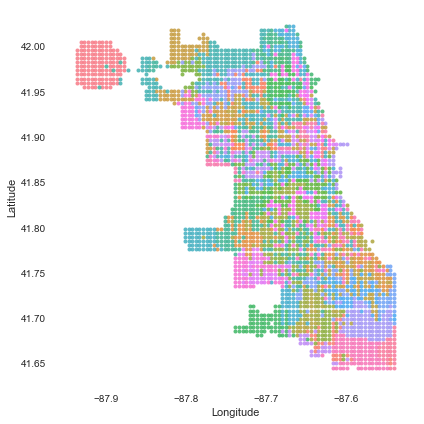

Total time: 29.3707029819
Regularization Penalty: 13774
Alpha: 0.9, K: 85, median EMD: 116.322319381

Done, Successful Convergence. Total Time: 347.816156149


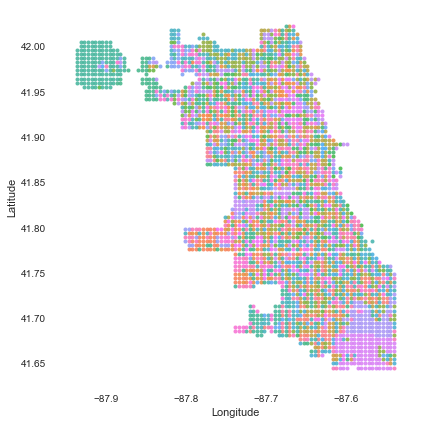

Total time: 29.4072010517
Regularization Penalty: 19254
Alpha: 0.99, K: 95, median EMD: 51.0468229219



In [50]:
optimal_run_list = [(0.01,105),(0.1,110),(0.2,100),(0.3,90),(0.4,100),(0.5,85),(0.6,90),(0.7,85),(0.8,100),(0.9,85),(0.99,95)]
                                                                       
data_for_norm5 = deepcopy(clustering_data)[['Latitude', 'Longitude', 'All Crime', 'Battery', 'Theft', 'Narcotics']]
for col in ['All Crime', 'Battery', 'Theft', 'Narcotics']:
    data_for_norm5[col] = (data_for_norm5[col]-data_for_norm5[col].mean())/data_for_norm5[col].std()

emd_list_5 = []
reg_pen_list_5 = []

for alp, k_val in optimal_run_list:
    df, error, sse5 = geo_k_means(data_for_norm5[['Latitude', 'Longitude', 'All Crime', 'Battery', 'Theft', 'Narcotics']], k_val, alpha=alp, cap=1000,verbose=False)
    str_lab = "Cluster_Label_A2_" + str(alp)
    clustering_grid[str_lab] = [int(i) for i in list(df.CLUSTER_LABEL)]
    
    sns.lmplot(x="Longitude", y="Latitude", data=clustering_grid, fit_reg=False, hue=str_lab, legend=False, scatter_kws={"s": 16}, size=6)
    plt.show()
    
    reg_pen5 = regularize(clustering_grid, str_lab)
    reg_pen_list_5.append(reg_pen5)
    
    all_c_emd = emd(clustering_grid, str_lab)
    emd_list_5.append(np.median(all_c_emd))
    print("Alpha: " + str(alp) + ", K: " + str(k_val) + ", median EMD: " + str(np.median(all_c_emd)))
    print                                                                       
                                                                       

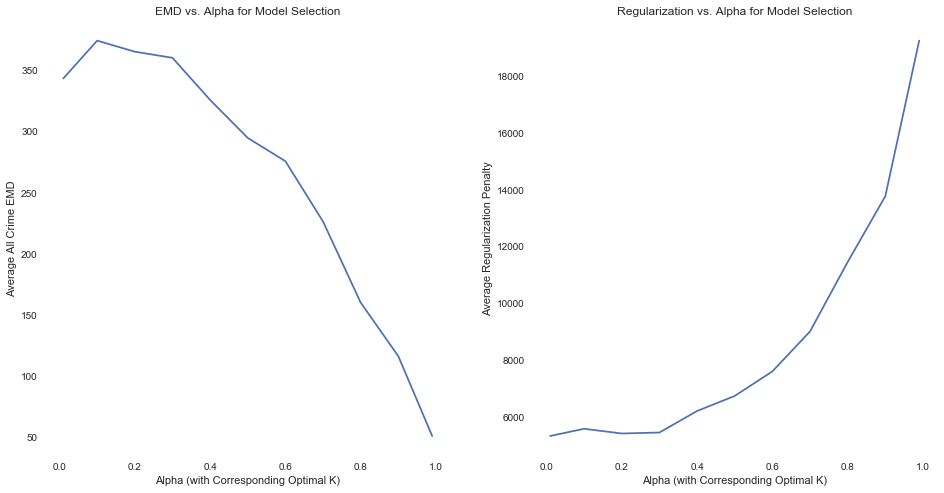

In [53]:
alphas = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]

fig, axs = plt.subplots(1,2, figsize=(16,8))
axs[0].plot(alphas, emd_list_5)
axs[0].set_xlabel("Alpha (with Corresponding Optimal K)")
axs[0].set_ylabel("Average All Crime EMD")
axs[0].set_title("EMD vs. Alpha for Model Selection")
axs[1].plot(alphas, reg_pen_list_5)
axs[1].set_xlabel("Alpha (with Corresponding Optimal K)")
axs[1].set_ylabel("Average Regularization Penalty")
axs[1].set_title("Regularization vs. Alpha for Model Selection")
plt.show()

#### Acceptable range is 0.4-0.7. Before 0.4, EMD is consistent so no confidence that we're improving beyond the baseline. After 0.7, regularization penalty skyrockets, and we can see in the maps that they start to get very random and don't look like real neighborhoods. Looking at the maps, I think alpha = 0.4, k=100 is a good map to choose, and it seems like we could use the idea of the regularization again to smooth out areas where there is a contribution of 7 or 8 to the regularization and re-assign these points to one of the neighboring clusters. 

### Here's what we're trying to fix.

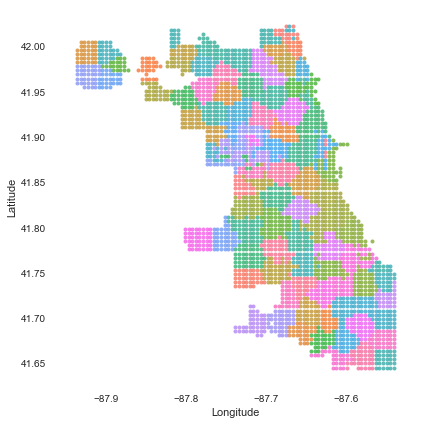

Number of Neighborhoods: 100
The average neighborhood all crime EMD is: 375.298335914, the median is: 332.367782076, the maximum is: 2601.37444256, and the minimum is: 4.02321645839
The average neighborhood all crime Standard Deviation is: 512.714675547, the median is: 427.860728416, the maximum is: 3467.82312842, and the minimum is: 9.38562546653
The regularization parameter is 7604


In [69]:
label="Cluster_Label_A2_0.4"
sns.lmplot(x="Longitude", y="Latitude", data=clustering_grid, fit_reg=False, hue=label, legend=False, scatter_kws={"s": 16}, size=6)
plt.show()

# Get baseline
print("Number of Neighborhoods: " + str(len(np.unique(list(clustering_grid[label])))))
all_c_emd6 = emd(clustering_grid[clustering_grid[label] > -1], label)
all_c_sd6 = sd(clustering_grid[clustering_grid[label] > -1], label)
print("The average neighborhood all crime EMD is: " + str(np.mean(all_c_emd6)) + ", the median is: " + str(np.median(all_c_emd6)) + ", the maximum is: " + str(np.max(all_c_emd6)) + ", and the minimum is: " + str(np.min(all_c_emd6)))
print("The average neighborhood all crime Standard Deviation is: " + str(np.mean(all_c_sd6)) + ", the median is: " + str(np.median(all_c_sd6)) + ", the maximum is: " + str(np.max(all_c_sd6)) + ", and the minimum is: " + str(np.min(all_c_sd6)))
print("The regularization parameter is " + str(reg_pen_list_5[6]))

In [70]:
s = time.time()
lats = set(list(clustering_grid.Latitude))
lons = set(list(clustering_grid.Longitude))

new_label = label + "_Fixed"
clustering_grid[new_label] = list(clustering_grid[label])
    
#total_existing = 0
total_reg_penalty = 0
#failures = 0
    
for index, row in clustering_grid.iterrows():
    #if index > 20:
    #    break
    lat = row.Latitude  
    lon = row.Longitude
    my_identity = row[label]

    try:
        lat_above = np.min([i for i in lats if i > lat])
    except:
        #failures = failures + 1
        lat_above = 0.0
    try:
        lat_below = np.max([i for i in lats if i < lat])
    except:
        #failures = failures + 1
        lat_below = 0.0
    try:
        lon_above = np.min([i for i in lons if i > lon])
    except:
        #failures = failures + 1
        lon_above = 0.0
    try:
        lon_below = np.max([i for i in lons if i < lon])
    except:
        #failures = failures + 1
        lon_below = 0.0

    lat_list = [i for i in [lat, lat_above, lat_below] if i != 0.0]
    lon_list = [i for i in [lon, lon_above, lon_below] if i != 0.0]
        
    contribution = 0
    neighboring_identities = []
    for latitude in lat_list:
        lat_cut = clustering_grid[clustering_grid.Latitude == latitude]
        for longitude in lon_list:
            #allegiance = data.loc[(data.Latitude == latitude) & (data.Longitude == longitude)][cluster_col]
            lon_cut = lat_cut[lat_cut.Longitude == longitude]
            allegiance = list(lon_cut[label])
            neighboring_identities.extend(allegiance)
            
            if len(allegiance) == 1:
                if not allegiance[0] == my_identity:
                    contribution = contribution + 1
    if contribution > 6:
        # reassign to something in the list of neighboring identites
        #most_common = max(set(neighboring_identities), key=neighboring_identities.count)
        
        # reassign to neighborhood with closest centroid
        dist_from_cent = {}
        for nei in list(set(neighboring_identities)):
            points_in_clust = clustering_grid[clustering_grid[label] == nei][['Latitude','Longitude','All Crime','Battery','Theft','Narcotics']]
            data_for_norm6 = deepcopy(points_in_clust)[['Latitude', 'Longitude', 'All Crime', 'Battery', 'Theft', 'Narcotics']]
            for col in ['All Crime', 'Battery', 'Theft', 'Narcotics']:
                data_for_norm6[col] = (data_for_norm6[col]-data_for_norm6[col].mean())/data_for_norm6[col].std()
            
            centroid = np.mean(data_for_norm6, axis=0)
            
            hav = hav_dist(lat, lon, centroid[0], centroid[1])
            v1 = np.array([row['All Crime'], row['Battery'], row['Theft'], row['Narcotics']])
            v2 = np.array(centroid[2:])
            vec = np.linalg.norm(v1-v2)
            dist = hav + vec
            
            dist_from_cent[nei] = dist
        most_common = min(dist_from_cent, key=dist_from_cent.get)
        if not my_identity == most_common:
            print("Updating this from " + str(my_identity) + " to " + str(most_common))
        clustering_grid.at[index, new_label] = most_common
print("Total time: " + str(time.time() - s))


Updating this from 12 to 81
Updating this from 46 to 40
Updating this from 34 to 44
Updating this from 66 to 38
Updating this from 73 to 67
Updating this from 76 to 85
Updating this from 76 to 85
Updating this from 75 to 60
Updating this from 60 to 75
Updating this from 73 to 76
Updating this from 76 to 37
Updating this from 75 to 37
Updating this from 75 to 60
Updating this from 37 to 71
Updating this from 37 to 71
Updating this from 67 to 76
Updating this from 76 to 67
Updating this from 1 to 66
Updating this from 60 to 71
Updating this from 76 to 37
Updating this from 37 to 94
Updating this from 20 to 76
Updating this from 31 to 42
Updating this from 66 to 31
Updating this from 37 to 94
Updating this from 37 to 94
Updating this from 76 to 98
Updating this from 66 to 31
Updating this from 66 to 31
Updating this from 20 to 94
Updating this from 30 to 82
Updating this from 27 to 88
Updating this from 19 to 99
Updating this from 19 to 54
Updating this from 54 to 30
Updating this from 55

Total time: 38.1560649872
Regularization Penalty: 5886


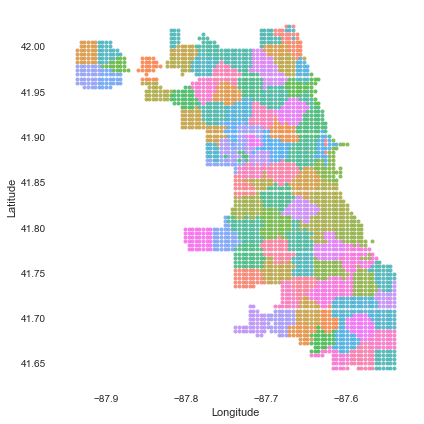

Number of Neighborhoods: 100
The average neighborhood all crime EMD is: 412.871064362, the median is: 334.165194388, the maximum is: 2972.997027, and the minimum is: 3.78306343507
The average neighborhood all crime Standard Deviation is: 560.944319622, the median is: 434.081596848, the maximum is: 3658.26829099, and the minimum is: 9.38562546653
The regularization parameter is 5886


In [71]:
reg = regularize(clustering_grid, new_label)

sns.lmplot(x="Longitude", y="Latitude", data=clustering_grid, fit_reg=False, hue=new_label, legend=False, scatter_kws={"s": 16}, size=6)
plt.show()

# Get baseline
print("Number of Neighborhoods: " + str(len(np.unique(list(clustering_grid[new_label])))))
all_c_emd7 = emd(clustering_grid[clustering_grid[new_label] > -1], new_label)
all_c_sd7 = sd(clustering_grid[clustering_grid[new_label] > -1], new_label)
print("The average neighborhood all crime EMD is: " + str(np.mean(all_c_emd7)) + ", the median is: " + str(np.median(all_c_emd7)) + ", the maximum is: " + str(np.max(all_c_emd7)) + ", and the minimum is: " + str(np.min(all_c_emd7)))
print("The average neighborhood all crime Standard Deviation is: " + str(np.mean(all_c_sd7)) + ", the median is: " + str(np.median(all_c_sd7)) + ", the maximum is: " + str(np.max(all_c_sd7)) + ", and the minimum is: " + str(np.min(all_c_sd7)))
print("The regularization parameter is " + str(reg))

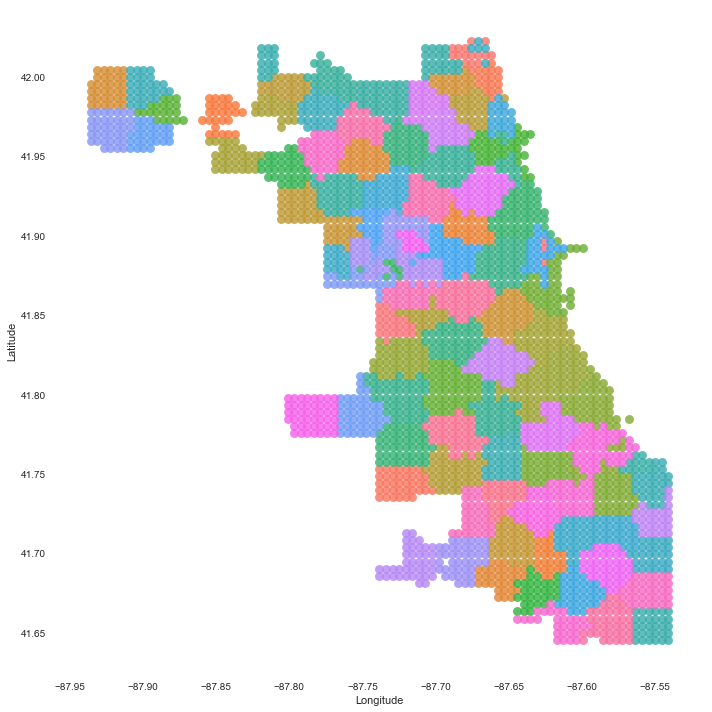

In [72]:
sns.lmplot(x="Longitude", y="Latitude", data=clustering_grid, fit_reg=False, hue=new_label, legend=False, scatter_kws={"s": 80}, size=10)
plt.show()

****

In [ ]:
lat_1s = [0.00, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
lat_2s = [0.00, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
lon_1s = [0.00, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
lon_2s = [0.00, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

euc_list = []
hav_list = []

for lat_1 in lat_1s:
    for lat_2 in lat_2s:
        for lon_1 in lon_1s:
            for lon_2 in lon_2s:
                hav_list.append(hav_dist(lat_1, lon_1, lat_2, lon_2))
                a = np.array([lat_1, lon_1])
                b = np.array([lat_2, lon_2])
                euc_list.append(np.linalg.norm(a-b))
                
fig, axs = plt.subplots(1,2, figsize=(12,7))
axs[0].plot(range(len(euc_list)), euc_list)
axs[0].set_title('Euclidean Distance')
axs[1].plot(range(len(hav_list)), hav_list)
axs[1].set_title('Haversine Distance')
plt.show()

In [84]:
len(clustering_grid[clustering_grid['Battery'] == 0])

333

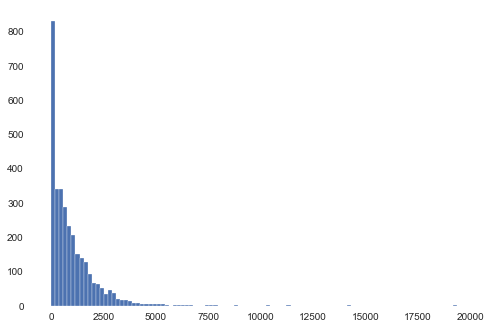

In [77]:
plt.hist(list(clustering_grid['All Crime']), bins=100)
plt.show()